In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class TrustedToRefined:
    trusted_folder = (
        Path("~/localdatalake/formula_one").expanduser() / "data" / "trusted"
    )
    refined_folder = (
        Path("~/localdatalake/formula_one").expanduser() / "data" / "refined"
    )

    def read_from_trusted(self, dataset_name):
        path = self.trusted_folder / (dataset_name + ".parquet")
        df = pd.read_parquet(path)
        return df

    def read_from_refined(self, dataset_name):
        path = self.refined_folder / (dataset_name + ".parquet")
        df = pd.read_parquet(path)
        return df

In [3]:
df_laps = TrustedToRefined().read_from_refined('SessionTiming_Y2023')

In [4]:
df_telemetry = TrustedToRefined().read_from_trusted('Position_Y2023')

In [5]:
df_laps[['event_type', 'lap_is_accurate']].value_counts()

event_type  lap_is_accurate
lap         True               13789
            False               5346
pit         False               1851
dtype: int64

In [6]:
pkey = [
    ('year', 'weekend_year'),
    ('round_number', 'weekend_index'),
    ('session_type', 'session_index'),
    ('DriverNumber', 'driver_id'),
    ('LapNumber', 'lap_number'),
]
df_timing = (
    df_telemetry.rename(columns={x[0]: x[1] for x in pkey})
    .assign(driver_id=lambda df: df['driver_id'].astype(pd.Int64Dtype()))
    .assign(lap_number=lambda df: df['lap_number'].astype(pd.Int64Dtype()))
    .merge(df_laps[[x[1] for x in pkey] + [
        'start_timestamp', 'end_timestamp', 'session_reference_time', 'session_start_time', 'lap_is_accurate',
    ]], on=[x[1] for x in pkey], suffixes=['', '_dup'])
)

In [7]:
df_timing.head().T

,0,1,2,3,4
Date,2023-03-05 15:03:38.686000,2023-03-05 15:03:38.946000,2023-03-05 15:03:39.046000,2023-03-05 15:03:39.265000,2023-03-05 15:03:39.625000
Status,OnTrack,OnTrack,OnTrack,OnTrack,OnTrack
X,-280,-280,-280,-280,-279
Y,3559,3559,3559,3564,3579
Z,-157,-157,-157,-157,-157
Source,pos,pos,pos,pos,pos
Time,0 days 00:00:00.185000,0 days 00:00:00.445000,0 days 00:00:00.545000,0 days 00:00:00.764000,0 days 00:00:01.124000
SessionTime,0 days 01:02:36.837000,0 days 01:02:37.097000,0 days 01:02:37.197000,0 days 01:02:37.416000,0 days 01:02:37.776000
lap_number,1,1,1,1,1
driver_id,1,1,1,1,1


In [8]:
check_df = df_timing.sample(n=1000)
check = (
    (
        check_df['Date'].dt.tz_localize('UTC')
        - check_df['start_timestamp']
    ).apply(lambda x: x.total_seconds())
    - check_df['Time'].apply(lambda x: x.total_seconds())
)

In [9]:
check.round(4).value_counts()

 0.000      780
-574.125      4
-480.952      2
-563.027      2
-711.201      2
           ... 
-433.631      1
-106.269      1
-653.590      1
-433.871      1
-309.373      1
Length: 200, dtype: int64

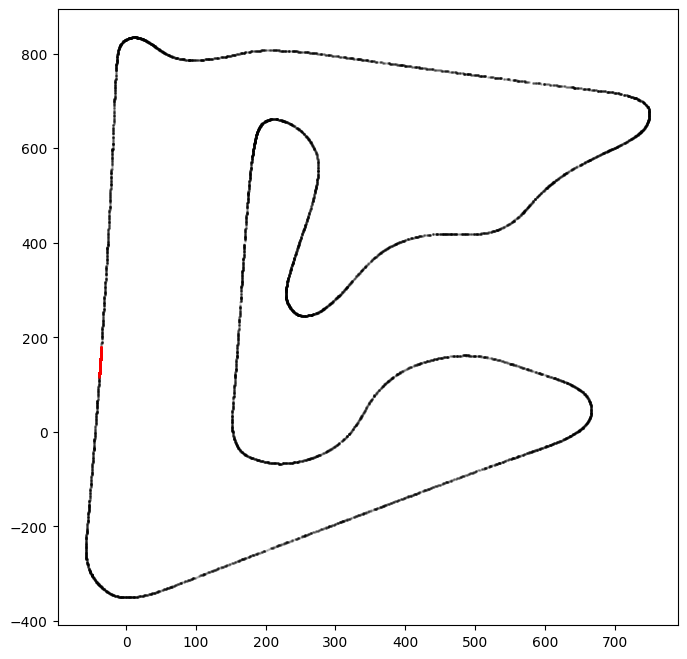

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_df_all = (
    df_timing[
        (df_timing['weekend_year']==2023)
        & (df_timing['weekend_index']==1)
        & (df_timing['lap_is_accurate'].fillna(False))
    ]
    .assign(time_=lambda df: df['Time'].apply(lambda x: x.total_seconds()))
)
plot_df = plot_df_all.sample(n=10000)
ax.scatter(plot_df['X']*0.1, plot_df['Y']*0.1, s=1, alpha=0.2, color='k')

plot_df = plot_df_all.query('(time_ > 0) & (time_ < 0.5)').sample(n=10000, replace=True)
ax.scatter(plot_df['X']*0.1, plot_df['Y']*0.1, s=1, alpha=0.2, color='r')


<AxesSubplot: ylabel='Frequency'>

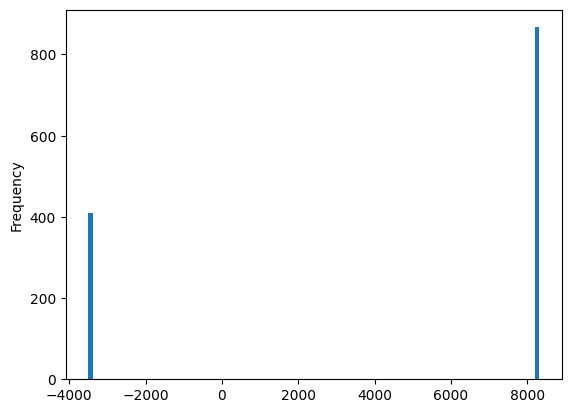

In [11]:
plot_df = plot_df_all.query('(X>-10) & (X<10)')
plot_df['Y'].plot.hist(bins=100)

In [12]:
def find_coordinates(data_input, coordinate_to_find):
    series = data_input[coordinate_to_find]
    rng = (min(series), max(series))
    rng_size = rng[1] - rng[0]
    min_ = rng[0] - 0.05 * rng_size
    max_ = rng[1] + 0.05 * rng_size
    bins = np.arange(min_, max_, 100)
    hist_values, hist_edges = np.histogram(series, bins=bins)
    hist_values = hist_values / hist_values.sum()
    return hist_values, hist_edges

In [13]:
find_coordinates(plot_df_all.query('(X>-10) & (X<10)'), 'Y')

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.32053292, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [14]:
help(np.arange)

Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None, *, like=None)
    
    Return evenly spaced values within a given interval.
    
    ``arange`` can be called with a varying number of positional arguments:
    
    * ``arange(stop)``: Values are generated within the half-open interval
      ``[0, stop)`` (in other words, the interval including `start` but
      excluding `stop`).
    * ``arange(start, stop)``: Values are generated within the half-open
      interval ``[start, stop)``.
    * ``arange(start, stop, step)`` Values are generated within the half-open
      interval ``[start, stop)``, with spacing between values given by
      ``step``.
    
    For integer arguments the function is roughly equivalent to the Python
    built-in :py:class:`range`, but returns an ndarray rather than a ``range``
    instance.
    
    When using a non-integer step, such as 0.1, it is often better to use
    `numpy.linspace`.
    
    S

In [15]:
plot_df_all['lap_is_accurate'].value_counts()

True    677567
Name: lap_is_accurate, dtype: int64

## Adding differential distance

In [16]:
def add_previous_point(df):
    for col in ['X', 'Y', 'Z', 'Time']:
        df['previous_' + col] = df[col].shift(1)
    diff_X = (df['X'] - df['previous_X'])
    diff_Y = (df['Y'] - df['previous_Y'])
    df['distance_XY'] = np.sqrt(diff_X**2 + diff_Y**2)
    df['elapsed_time'] = np.sqrt(
        (df['Time'] - df['previous_Time']).apply(lambda x: x.total_seconds())
    )
    df['cumulative_distance'] = df['distance_XY'].fillna(0).cumsum()
    df['displacement_angle_cos'] = diff_X / df['distance_XY']
    df['displacement_angle_sin'] = diff_Y / df['distance_XY']
    return df

In [17]:
df_with_previous = (
    plot_df_all
    .sort_values(by=['Time'])
    .groupby(['weekend_year', 'weekend_index', 'session_index', 'driver_id', 'lap_number'])
    .apply(add_previous_point)
)

/var/folders/n9/qtf08bkx00z3xzx24pfblmhc0000gp/T/ipykernel_12370/2760387048.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  plot_df_all


In [18]:
df_with_previous.query('(session_index==5)&(driver_id==1)&(lap_number==2)').sort_values(by=['Time'])

,Date,Status,X,Y,Z,Source,Time,SessionTime,lap_number,driver_id,...,time_,previous_X,previous_Y,previous_Z,previous_Time,distance_XY,elapsed_time,cumulative_distance,displacement_angle_cos,displacement_angle_sin
380,2023-03-05 15:05:17.846,OnTrack,-380,1291,-159,pos,0 days 00:00:00.036000,0 days 01:04:15.997000,2,1,...,0.036,NaN,NaN,NaN,NaT,NaN,NaN,0.000000,NaN,NaN
381,2023-03-05 15:05:18.045,OnTrack,-372,1447,-159,pos,0 days 00:00:00.235000,0 days 01:04:16.196000,2,1,...,0.235,-380.0,1291.0,-159.0,0 days 00:00:00.036000,156.204994,0.446094,156.204994,0.051215,0.998688
382,2023-03-05 15:05:18.205,OnTrack,-366,1573,-159,pos,0 days 00:00:00.395000,0 days 01:04:16.356000,2,1,...,0.395,-372.0,1447.0,-159.0,0 days 00:00:00.235000,126.142776,0.400000,282.347770,0.047565,0.998868
383,2023-03-05 15:05:18.425,OnTrack,-358,1746,-159,pos,0 days 00:00:00.615000,0 days 01:04:16.576000,2,1,...,0.615,-366.0,1573.0,-159.0,0 days 00:00:00.395000,173.184872,0.469042,455.532642,0.046193,0.998933
384,2023-03-05 15:05:18.626,OnTrack,-348,1984,-159,pos,0 days 00:00:00.816000,0 days 01:04:16.777000,2,1,...,0.816,-358.0,1746.0,-159.0,0 days 00:00:00.615000,238.209991,0.448330,693.742633,0.041980,0.999118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2023-03-05 15:06:54.586,OnTrack,-428,334,-159,pos,0 days 00:01:36.776000,0 days 01:05:52.737000,2,1,...,96.776,-441.0,95.0,-159.0,0 days 00:01:36.376000,239.353295,0.632456,52415.872846,0.054313,0.998524
749,2023-03-05 15:06:54.746,OnTrack,-417,546,-159,pos,0 days 00:01:36.936000,0 days 01:05:52.897000,2,1,...,96.936,-428.0,334.0,-159.0,0 days 00:01:36.776000,212.285186,0.400000,52628.158032,0.051817,0.998657
750,2023-03-05 15:06:55.086,OnTrack,-409,714,-159,pos,0 days 00:01:37.276000,0 days 01:05:53.237000,2,1,...,97.276,-417.0,546.0,-159.0,0 days 00:01:36.936000,168.190368,0.583095,52796.348400,0.047565,0.998868
751,2023-03-05 15:06:55.386,OnTrack,-397,949,-159,pos,0 days 00:01:37.576000,0 days 01:05:53.537000,2,1,...,97.576,-409.0,714.0,-159.0,0 days 00:01:37.276000,235.306184,0.547723,53031.654583,0.050997,0.998699


<AxesSubplot: ylabel='Frequency'>

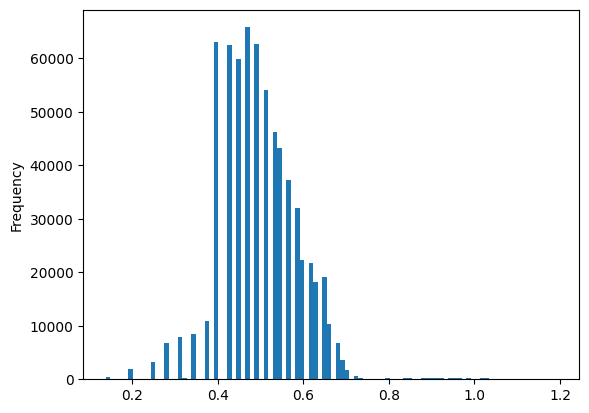

In [19]:
df_with_previous['elapsed_time'].plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

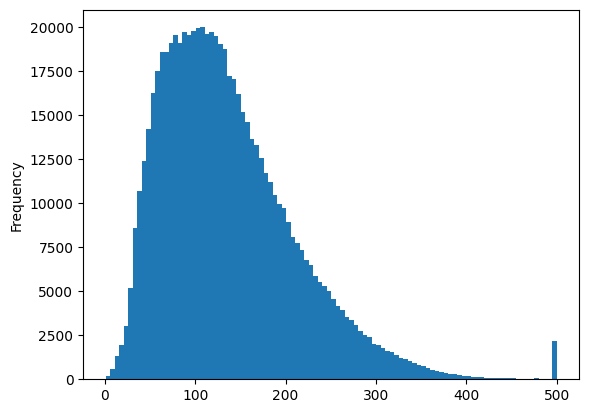

In [117]:
df_with_previous['distance_XY'].apply(lambda x: x if x>0 else None).clip(upper=500).plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

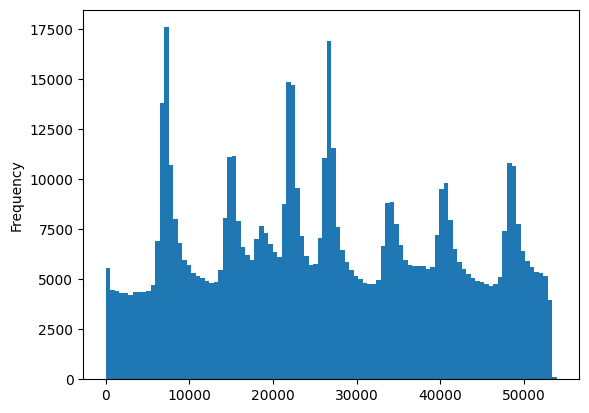

In [20]:
df_with_previous['cumulative_distance'].plot.hist(bins=100)

In [21]:
def filter_by_cumulative_distance(df, distance, size):
    df_out = df[
        (df['cumulative_distance'] > distance - size)
        & (df['cumulative_distance'] < distance + size)
    ]
    cols = ['X', 'Y', 'Z', 'displacement_angle_cos', 'displacement_angle_sin']
    return {
        'count': len(df_out),
        'mean': df_out[cols].mean().to_dict(),
        'std': df_out[cols].std().to_dict(),
    }


In [22]:
filter_by_cumulative_distance(df_with_previous, 1000, 10)

{'count': 155,
 'mean': {'X': -331.2903225806452,
  'Y': 2399.9483870967742,
  'Z': -158.84516129032258,
  'displacement_angle_cos': 0.03965708807290387,
  'displacement_angle_sin': 0.9992098294485237},
 'std': {'X': 4.385584031558787,
  'Y': 103.62750434355041,
  'Z': 0.36292347381022366,
  'displacement_angle_cos': 0.002658321981910701,
  'displacement_angle_sin': 0.00010529126842589134}}

In [23]:
df_with_previous['cumulative_distance'].max()

53879.85765301716

In [24]:
dff = pd.DataFrame([
    {'distance': x, **filter_by_cumulative_distance(df_with_previous, x, 100)}
    for x in np.arange(0, df_with_previous['cumulative_distance'].max(), 10)
])

In [25]:
dff

,distance,count,mean,std
0,0.0,1834,"{'X': -374.31297709923666, 'Y': 1401.884405670...","{'X': 4.927092627445888, 'Y': 103.910447338143..."
1,10.0,1851,"{'X': -374.26526202052946, 'Y': 1402.917882225...","{'X': 4.965761493979742, 'Y': 104.764104431577..."
2,20.0,1888,"{'X': -374.1393008474576, 'Y': 1405.6011652542...","{'X': 5.048800739986928, 'Y': 106.598267378388..."
3,30.0,2012,"{'X': -373.83300198807154, 'Y': 1411.988568588...","{'X': 5.132548832466083, 'Y': 108.342708957848..."
4,40.0,2061,"{'X': -373.66132945172245, 'Y': 1415.643377001...","{'X': 5.25198103896443, 'Y': 111.0168422499641..."
...,...,...,...,...
5383,53830.0,2,"{'X': -380.0, 'Y': 1278.5, 'Z': -159.0, 'displ...","{'X': 1.4142135623730951, 'Y': 23.334523779156..."
5384,53840.0,2,"{'X': -380.0, 'Y': 1278.5, 'Z': -159.0, 'displ...","{'X': 1.4142135623730951, 'Y': 23.334523779156..."
5385,53850.0,2,"{'X': -380.0, 'Y': 1278.5, 'Z': -159.0, 'displ...","{'X': 1.4142135623730951, 'Y': 23.334523779156..."
5386,53860.0,2,"{'X': -380.0, 'Y': 1278.5, 'Z': -159.0, 'displ...","{'X': 1.4142135623730951, 'Y': 23.334523779156..."


<ErrorbarContainer object of 3 artists>

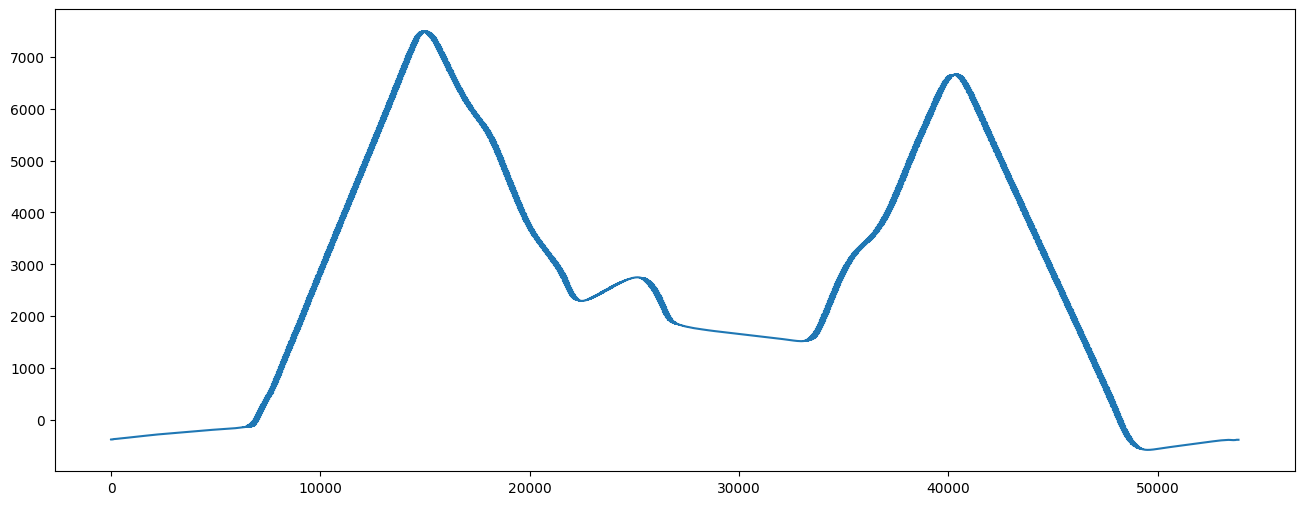

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.errorbar(
    dff['distance'],
    dff['mean'].apply(lambda x: x['X']),
    yerr=dff['std'].apply(lambda x: x['X']),
)

<ErrorbarContainer object of 3 artists>

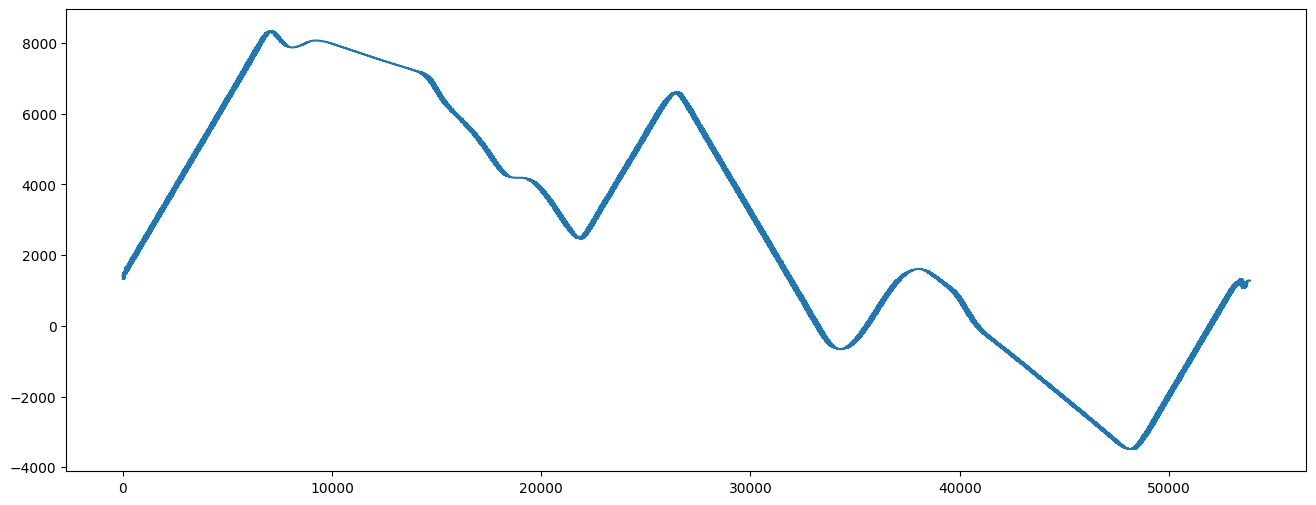

In [27]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.errorbar(
    dff['distance'],
    dff['mean'].apply(lambda x: x['Y']),
    yerr=dff['std'].apply(lambda x: x['Y']),
)

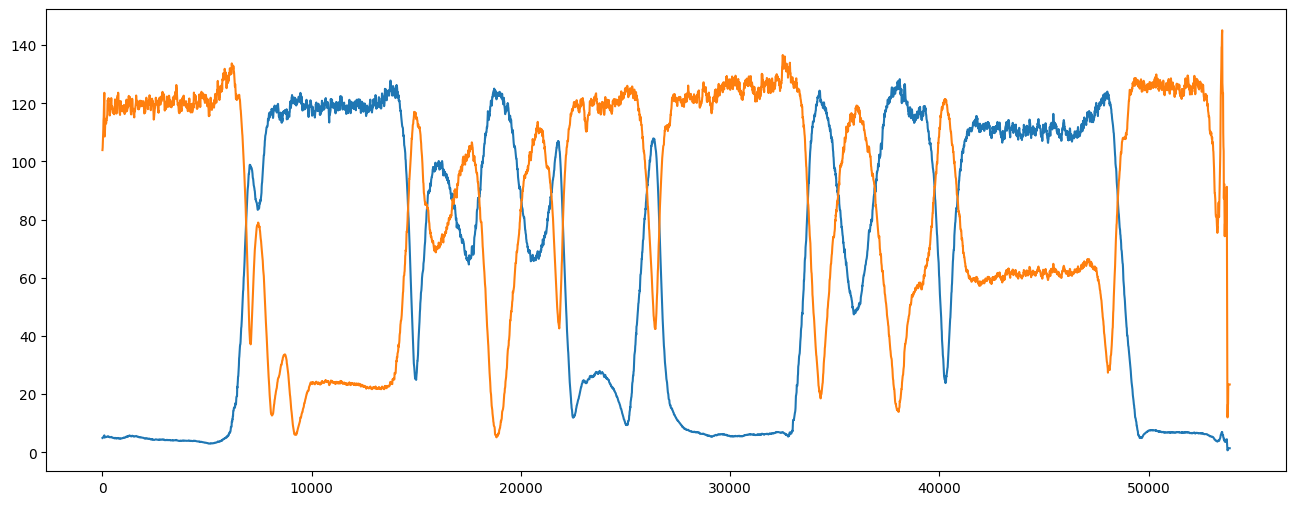

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    dff['distance'],
    dff['std'].apply(lambda x: x['X']),
)
ax.plot(
    dff['distance'],
    dff['std'].apply(lambda x: x['Y']),
)

<ErrorbarContainer object of 3 artists>

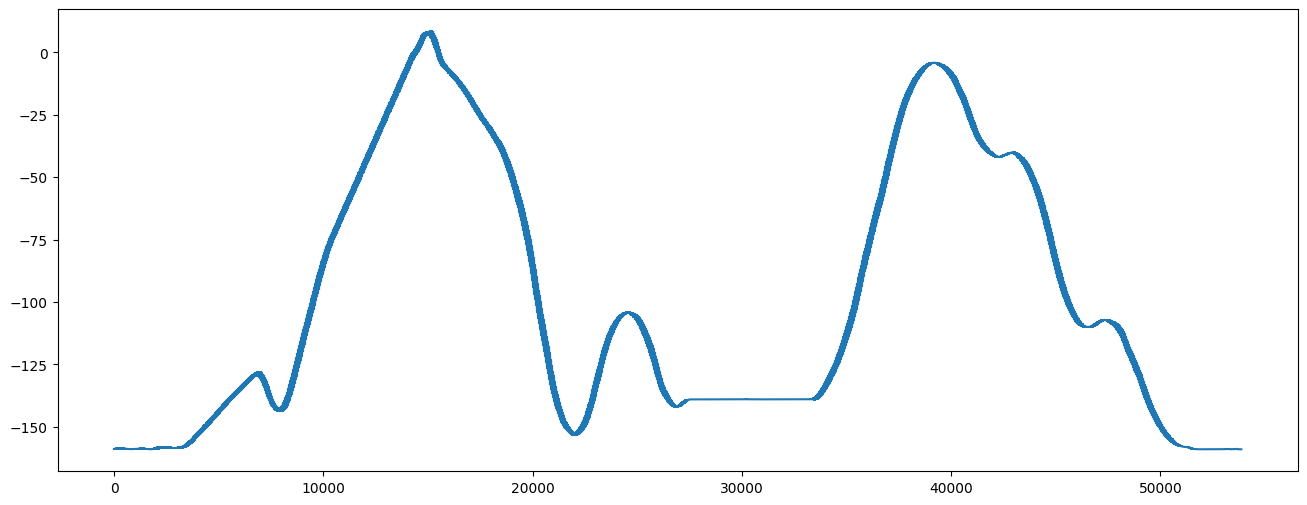

In [29]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.errorbar(
    dff['distance'],
    dff['mean'].apply(lambda x: x['Z']),
    yerr=dff['std'].apply(lambda x: x['Z']),
)

In [30]:
track = dff[[]].copy()
track['distance_m'] = dff['distance'] / 10
for col in ['X', 'Y', 'Z', 'displacement_angle_cos', 'displacement_angle_sin']:
    track[col] = dff['mean'].apply(lambda x, c=col: x[c])
track['displacement_angle'] = np.arctan2(
    track['displacement_angle_sin'],
    track['displacement_angle_cos'],
)

In [31]:
track

,distance_m,X,Y,Z,displacement_angle_cos,displacement_angle_sin,displacement_angle
0,0.0,-374.312977,1401.884406,-158.895856,0.047760,0.998842,1.523017
1,1.0,-374.265262,1402.917882,-158.895732,0.047633,0.998850,1.523144
2,2.0,-374.139301,1405.601165,-158.890890,0.047551,0.998856,1.523227
3,3.0,-373.833002,1411.988569,-158.885686,0.047535,0.998861,1.523243
4,4.0,-373.661329,1415.643377,-158.882581,0.047471,0.998864,1.523307
...,...,...,...,...,...,...,...
5383,5383.0,-380.000000,1278.500000,-159.000000,0.049466,0.998776,1.521310
5384,5384.0,-380.000000,1278.500000,-159.000000,0.049466,0.998776,1.521310
5385,5385.0,-380.000000,1278.500000,-159.000000,0.049466,0.998776,1.521310
5386,5386.0,-380.000000,1278.500000,-159.000000,0.049466,0.998776,1.521310


In [32]:
diff_X = (track['X'] - track['X'].shift(1))
diff_Y = (track['Y'] - track['Y'].shift(1))
dist = np.sqrt(diff_X**2 + diff_Y**2)

<AxesSubplot: ylabel='Frequency'>

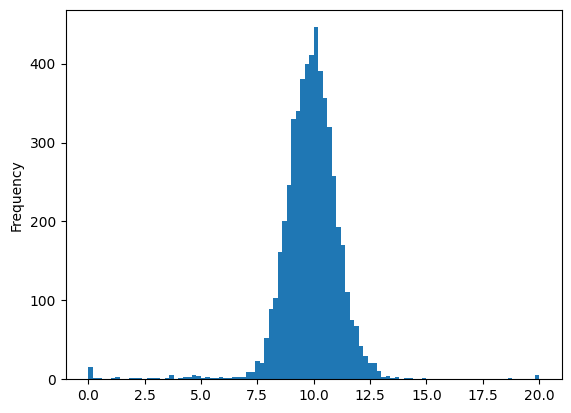

In [33]:
dist.clip(upper=20).plot.hist(bins=100)

<ErrorbarContainer object of 3 artists>

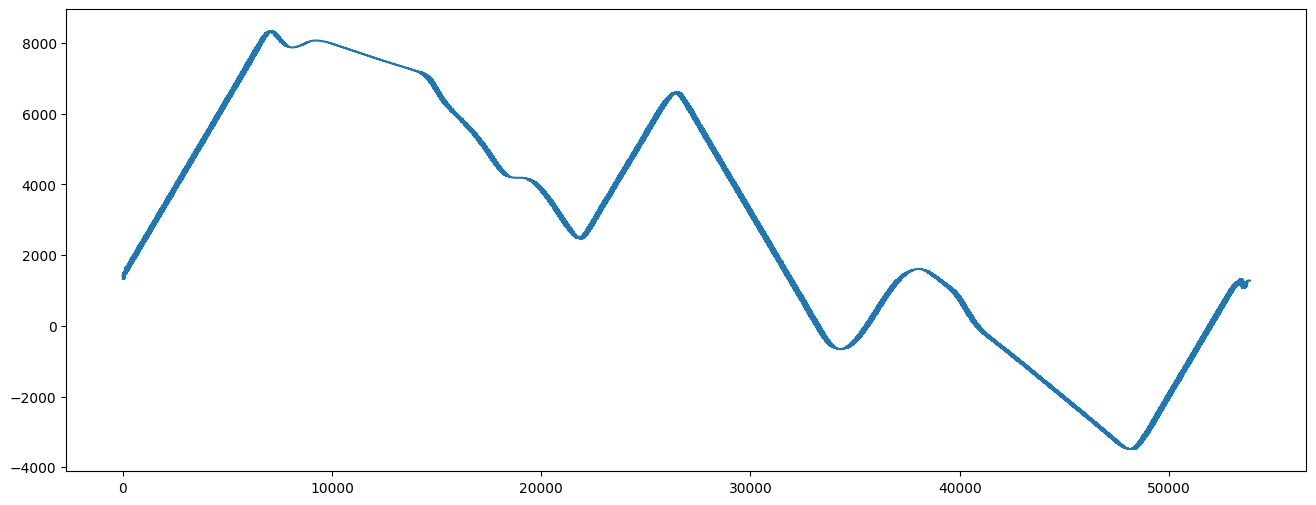

In [34]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.errorbar(
    dff['distance'],
    dff['mean'].apply(lambda x: x['Y']),
    yerr=dff['std'].apply(lambda x: x['Y']),
)

In [35]:
fourier_dit = np.fft.fft(dff['mean'].apply(lambda x: x['Y']))
fourier_inv = np.fft.ifft(fourier_dit)

/Users/tiagobbatalhao/.virtualenvs/formula_one/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


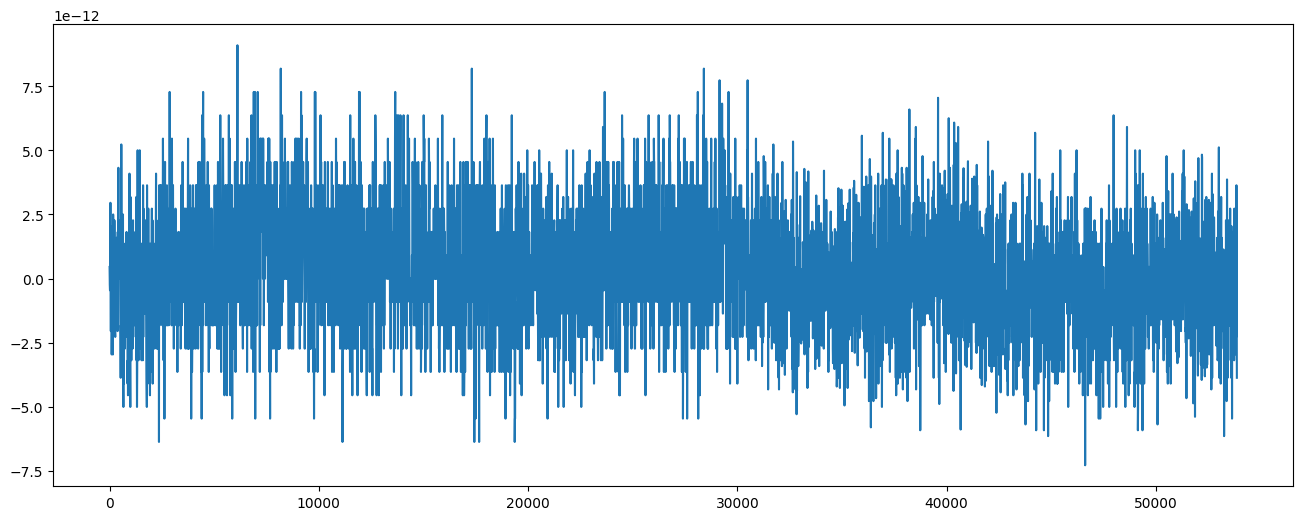

In [36]:
fig, ax = plt.subplots(figsize=(16, 6))
# ax.plot(dff['distance'], dff['mean'].apply(lambda x: x['Y']))
# ax.plot(dff['distance'], fourier_inv)
ax.plot(dff['distance'], dff['mean'].apply(lambda x: x['Y']) - fourier_inv)


In [37]:
freq = np.fft.fftfreq(len(dff['mean']))

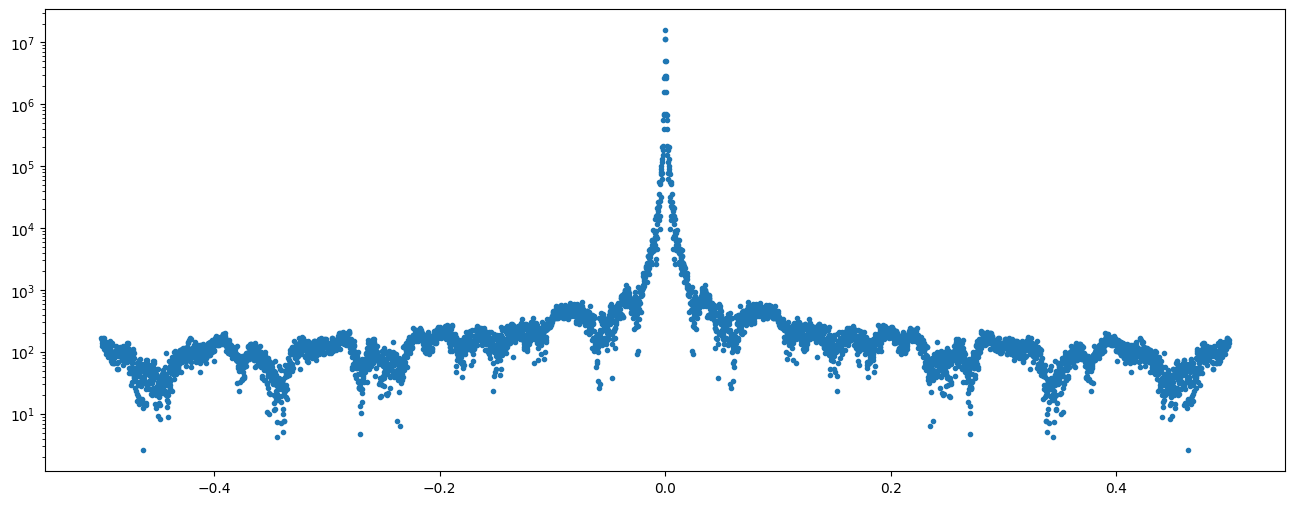

In [38]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(freq, np.abs(fourier_dit), '.');
ax.set_yscale('log')

In [39]:
freq

array([ 0.        ,  0.0001856 ,  0.0003712 , ..., -0.00055679,
       -0.0003712 , -0.0001856 ])

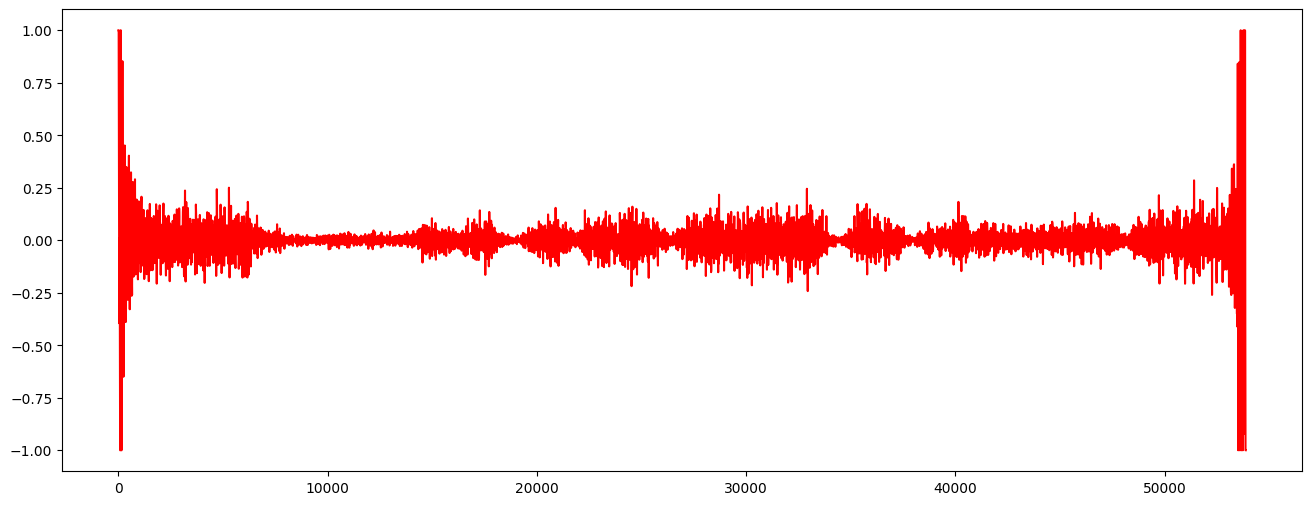

In [40]:
y_rec = np.fft.ifft([y if abs(x)<0.1 else 0 for x, y in zip(freq, fourier_dit)])
fig, ax = plt.subplots(figsize=(16, 6))
# ax.plot(dff['distance'], dff['mean'].apply(lambda x: x['Y']))
# ax.plot(dff['distance'], y_rec, color='r')
ax.plot(dff['distance'], (dff['mean'].apply(lambda x: x['Y'])-y_rec).clip(upper=10, lower=-10)/10, color='r')


In [41]:
df_with_previous

,Date,Status,X,Y,Z,Source,Time,SessionTime,lap_number,driver_id,...,time_,previous_X,previous_Y,previous_Z,previous_Time,distance_XY,elapsed_time,cumulative_distance,displacement_angle_cos,displacement_angle_sin
6157555,2023-03-03 15:50:47.498,OnTrack,-380,1283,-159,pos,0 days 00:00:00,0 days 01:05:47.491000,21,21,...,0.000,NaN,NaN,NaN,NaT,NaN,NaN,0.000000,NaN,NaN
6086327,2023-03-03 15:58:31.899,OnTrack,-380,1291,-159,pos,0 days 00:00:00,0 days 01:13:31.892000,23,31,...,0.000,NaN,NaN,NaN,NaT,NaN,NaN,0.000000,NaN,NaN
6296578,2023-03-03 15:07:13.452,OnTrack,-382,1252,-159,pos,0 days 00:00:00,0 days 00:22:13.445000,4,81,...,0.000,NaN,NaN,NaN,NaT,NaN,NaN,0.000000,NaN,NaN
2406896,2023-03-04 15:46:34.699,OnTrack,-378,1317,-159,pos,0 days 00:00:00,0 days 01:01:33.702000,13,27,...,0.000,NaN,NaN,NaN,NaT,NaN,NaN,0.000000,NaN,NaN
7171508,2023-03-04 12:02:53.846,OnTrack,-380,1293,-159,pos,0 days 00:00:00,0 days 00:47:53.842000,9,4,...,0.000,NaN,NaN,NaN,NaT,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106264,2023-03-04 12:27:23.433,OnTrack,-388,1110,-159,pos,0 days 00:02:29.264000,0 days 01:12:23.429000,17,20,...,149.264,-393.0,1010.0,-159.0,0 days 00:02:28.944000,100.124922,0.565685,53077.399843,0.049938,0.998752
6981947,2023-03-04 12:00:00.086,OnTrack,-398,925,-159,pos,0 days 00:02:29.271000,0 days 00:45:00.082000,4,1,...,149.271,-401.0,861.0,-159.0,0 days 00:02:29.191000,64.070274,0.282843,53092.524835,0.046824,0.998903
7038339,2023-03-04 11:39:49.326,OnTrack,-403,811,-159,pos,0 days 00:02:29.282000,0 days 00:24:49.322000,3,27,...,149.282,-416.0,578.0,-159.0,0 days 00:02:28.902000,233.362379,0.616441,52564.509282,0.055707,0.998447
7038340,2023-03-04 11:39:49.506,OnTrack,-391,1064,-159,pos,0 days 00:02:29.462000,0 days 00:24:49.502000,3,27,...,149.462,-403.0,811.0,-159.0,0 days 00:02:29.282000,253.284425,0.424264,52817.793707,0.047378,0.998877


In [86]:
markov_transition_matrix = pd.pivot_table(
    df_with_previous.dropna(subset=['previous_X', 'previous_Y']).assign(
        origin_x=lambda df: df['X'].apply(lambda val: int(val/100)),
        origin_y=lambda df: df['Y'].apply(lambda val: int(val/100)),
        dest_x=lambda df: df['previous_X'].apply(lambda val: int(val/100)),
        dest_y=lambda df: df['previous_Y'].apply(lambda val: int(val/100)),
    ).assign(
        count=lambda df: df.apply(
            lambda row: 1 if (row['origin_x']!=row['dest_x']) or (row['origin_y']!=row['dest_y']) else 1,
            axis=1,
        )
    ),
    columns=['origin_x', 'origin_y'],
    index=['dest_x', 'dest_y'],
    values='count',
    aggfunc='sum'
)

In [87]:
markov_transition_matrix.shape

(644, 644)

In [88]:
mat = markov_transition_matrix / markov_transition_matrix.sum(axis=0)

In [89]:
mat.sum(axis=1)

dest_x  dest_y
-5      -30       0.104392
        -29       1.084836
        -28       1.081871
        -27       1.064972
        -26       1.047006
                    ...   
 74      65       1.082213
         66       0.981091
         67       0.987907
         68       1.029010
         69       0.987699
Length: 644, dtype: float64

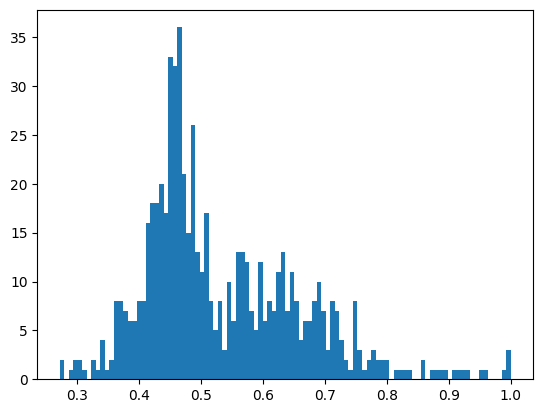

In [90]:
fig, ax = plt.subplots()
ax.hist(mat.max(axis=0), bins=100);

In [91]:
q = mat.max(axis=0)
q[q<0.5]

origin_x  origin_y
-5        -20         0.485222
          -18         0.456502
          -17         0.460526
          -16         0.481414
          -15         0.431481
                        ...   
 68        72         0.444072
 69        71         0.426657
 71        61         0.456468
 72        62         0.490618
 73        63         0.478423
Length: 335, dtype: float64

In [92]:
markov_transition_matrix.loc[:, (-5, -18)].dropna()

dest_x  dest_y
-5      -23         5.0
        -22         2.0
        -21        64.0
        -20       496.0
        -19       509.0
        -18        39.0
Name: (-5, -18), dtype: float64

In [93]:
markov_transition_matrix

origin_x       -5                                                          \
origin_y       -30    -29     -28     -27    -26    -25    -24   -23  -22   
dest_x dest_y                                                               
-5     -30     1.0  103.0    56.0     3.0    NaN    1.0    NaN   NaN  NaN   
       -29     NaN  248.0  1152.0   293.0    9.0    4.0    6.0   NaN  NaN   
       -28     NaN    NaN   173.0  1032.0  359.0   11.0    3.0   1.0  3.0   
       -27     NaN    NaN     NaN   136.0  907.0  407.0   20.0   2.0  1.0   
       -26     NaN    NaN     NaN     NaN  115.0  839.0  401.0  30.0  2.0   
...            ...    ...     ...     ...    ...    ...    ...   ...  ...   
 74     65     NaN    NaN     NaN     NaN    NaN    NaN    NaN   NaN  NaN   
        66     NaN    NaN     NaN     NaN    NaN    NaN    NaN   NaN  NaN   
        67     NaN    NaN     NaN     NaN    NaN    NaN    NaN   NaN  NaN   
        68     NaN    NaN     NaN     NaN    NaN    NaN    NaN   NaN  NaN   
        69     NaN    NaN     NaN     NaN    NaN    NaN    NaN   NaN  NaN   

origin_x            ...    73            74                                  \
origin_y       -21  ...    63  69  70    63      64      65      66      67   
dest_x dest_y       ...                                                       
-5     -30     NaN  ...   NaN NaN NaN   NaN     NaN     NaN     NaN     NaN   
       -29     NaN  ...   NaN NaN NaN   NaN     NaN     NaN     NaN     NaN   
       -28     2.0  ...   NaN NaN NaN   NaN     NaN     NaN     NaN     NaN   
       -27     1.0  ...   NaN NaN NaN   NaN     NaN     NaN     NaN     NaN   
       -26     2.0  ...   NaN NaN NaN   NaN     NaN     NaN     NaN     NaN   
...            ...  ...   ...  ..  ..   ...     ...     ...     ...     ...   
 74     65     NaN  ...  27.0 NaN NaN  50.0  1555.0   581.0     NaN     NaN   
        66     NaN  ...   8.0 NaN NaN   4.0    79.0  1509.0   542.0     NaN   
        67     NaN  ...   2.0 NaN NaN   NaN    11.0   120.0  1483.0   499.0   
        68     NaN  ...   NaN NaN NaN   NaN     4.0     7.0   109.0  1502.0   
        69     NaN  ...   NaN NaN NaN   NaN     NaN     1.0     5.0   106.0   

origin_x                      
origin_y           68     69  
dest_x dest_y                 
-5     -30        NaN    NaN  
       -29        NaN    NaN  
       -28        NaN    NaN  
       -27        NaN    NaN  
       -26        NaN    NaN  
...               ...    ...  
 74     65        NaN    NaN  
        66        NaN    NaN  
        67        NaN    NaN  
        68      579.0    NaN  
        69     1508.0  539.0  

[644 rows x 644 columns]

In [105]:
square_size = 200
transitions = (
    df_with_previous.dropna(subset=['previous_X', 'previous_Y']).assign(
        origin_x=lambda df: df['X'].apply(lambda val: int(val/square_size)),
        origin_y=lambda df: df['Y'].apply(lambda val: int(val/square_size)),
        dest_x=lambda df: df['previous_X'].apply(lambda val: int(val/square_size)),
        dest_y=lambda df: df['previous_Y'].apply(lambda val: int(val/square_size)),
    ).assign(
        count=lambda df: df.apply(
            lambda row: 1 if (row['origin_x']!=row['dest_x']) or (row['origin_y']!=row['dest_y']) else 1,
            axis=1,
        )
    ).groupby(
        ['origin_x', 'origin_y', 'dest_x', 'dest_y'],
        as_index=False
    ).agg({'count': 'sum'}).assign(
        displacement_x=lambda df: df['dest_x']-df['origin_x'],
        displacement_y=lambda df: df['dest_y']-df['origin_y'],
    )

)

In [106]:
q = transitions.groupby(['displacement_x', 'displacement_y'], as_index=False).agg({'count': 'sum'})
q['fraction'] = q['count'] / q['count'].sum()
q.sort_values(by='count', ascending=False).head(10)

,displacement_x,displacement_y,count,fraction
35,0,0,241196,0.356893
34,0,-1,109675,0.162284
36,0,1,85561,0.126603
25,-1,0,73318,0.108487
45,1,0,61310,0.090719
46,1,1,41820,0.061880
26,-1,1,15694,0.023222
24,-1,-1,14143,0.020927
33,0,-2,11318,0.016747
44,1,-1,5219,0.007722


In [108]:
q = transitions.assign(
    manhattan=lambda df: (df['displacement_x'].abs()+df['displacement_y'].abs()).clip(upper=10)
).groupby(['manhattan'], as_index=False).agg({'count': 'sum'})
q['fraction'] = q['count'] / q['count'].sum()
q.sort_values(by='manhattan', ascending=True).head(10)

,manhattan,count,fraction
0,0,241196,0.356893
1,1,329864,0.488093
2,2,96801,0.143234
3,3,6581,0.009738
4,4,841,0.001244
5,5,422,0.000624
6,6,99,0.000146
7,7,15,0.000022
8,8,2,0.000003
9,9,1,0.000001


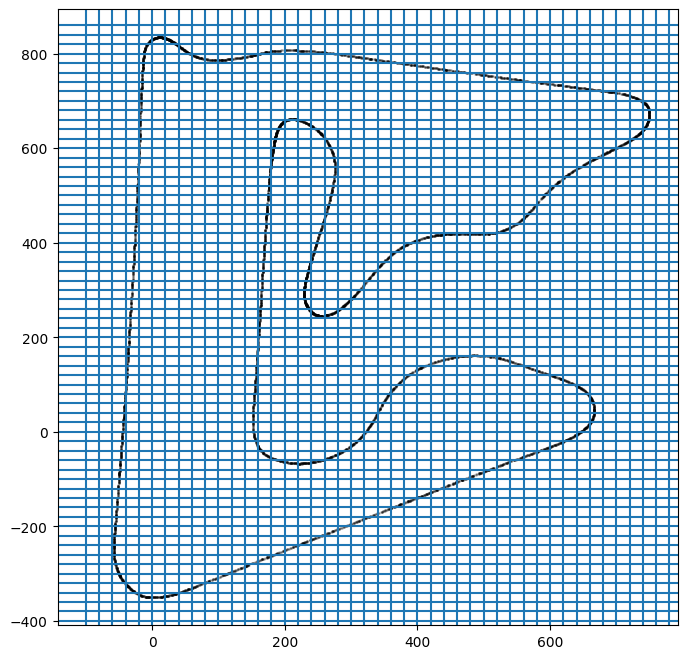

In [142]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_df_all = (
    df_timing[
        (df_timing['weekend_year']==2023)
        & (df_timing['weekend_index']==1)
        & (df_timing['lap_is_accurate'].fillna(False))
    ]
    .assign(time_=lambda df: df['Time'].apply(lambda x: x.total_seconds()))
)
plot_df = plot_df_all.sample(n=10000)
ax.scatter(plot_df['X']*0.1, plot_df['Y']*0.1, s=1, alpha=0.2, color='k')

square_size = 200
rng_x = np.arange(
    int(plot_df['X'].min() / square_size) - 3,
    int(plot_df['X'].max() / square_size) + 3,
)
for x in rng_x:
    ax.axvline(x * square_size * 0.1)
rng_y = np.arange(
    int(plot_df['Y'].min() / square_size) - 3,
    int(plot_df['Y'].max() / square_size) + 3,
)
for y in rng_y:
    ax.axhline(y * square_size * 0.1)


In [179]:
square_size = 100
square_occupations = (
    df_with_previous.dropna(subset=['previous_X', 'previous_Y']).assign(
        origin_x=lambda df: df['X'].apply(lambda val: int(val/square_size)),
        origin_y=lambda df: df['Y'].apply(lambda val: int(val/square_size)),
    ).assign(count=1).groupby(
        ['origin_x', 'origin_y'],
        as_index=False
    ).agg({'count': 'sum'})

)

<AxesSubplot: ylabel='Frequency'>

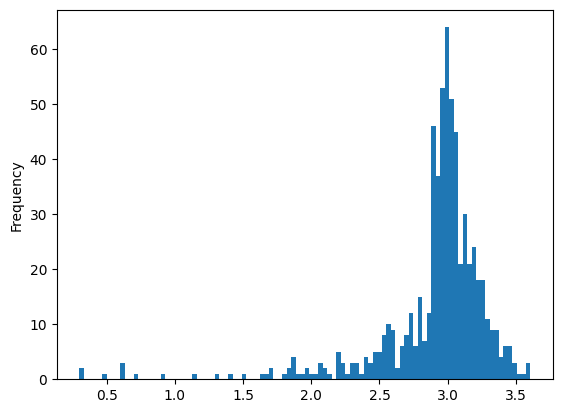

In [180]:
square_occupations['count'].apply(np.log10).plot.hist(bins=100)

In [181]:
import networkx as nx
graph = nx.Graph()
for _, row in square_occupations.iterrows():
    if row['count'] > 10:
        graph.add_node(
            (row['origin_x'], row['origin_y']),
            size=row['count']
        )
for ndA in graph.nodes:
    for ndB in graph.nodes:
        diff_X = ndA[0] - ndB[0]
        diff_Y = ndA[1] - ndB[1]
        is_neighbour = (
            (abs(diff_X)==1) & (abs(diff_Y)==0)
            | (abs(diff_X)==0) & (abs(diff_Y)==1)
        )
        if is_neighbour:
            graph.add_edge(ndA, ndB)


In [182]:
len(graph.nodes), len(graph.edges)

(636, 636)

In [183]:
components_ = list(nx.connected_components(graph))
len(components_)

1

In [184]:
[len(x) for x in components_]

[636]

In [185]:
import collections
collections.Counter([nx.degree(graph, x) for x in graph.nodes])

Counter({2: 630, 1: 3, 3: 3})

In [248]:
from h3 import h3
class LinearPointsToH3:
    EARTH_RADIUS = 6371 * 1e4
    DEGREE_TO_RADIANS = np.pi / 180

    def __init__(self, radius_multiplier=1):
        self.EARTH_RADIUS_C = self.EARTH_RADIUS * radius_multiplier

    def transform(self, X, Y):
        xx = X / self.EARTH_RADIUS_C
        yy = Y / self.EARTH_RADIUS_C
        latitude = np.arctan2(yy, np.sqrt(1+xx**2)) / self.DEGREE_TO_RADIANS
        longitude = np.arctan2(xx, 1) / self.DEGREE_TO_RADIANS
        cell = h3.geo_to_h3(latitude, longitude, 15)
        return cell
    
    def inverse_transform(self, cell):
        lat_deg, lng_deg = h3.h3_to_geo(cell)
        xx = np.tan(lng_deg * self.DEGREE_TO_RADIANS)
        yy = np.sqrt(1+xx**2) * np.tan(lat_deg * self.DEGREE_TO_RADIANS)
        return [x*self.EARTH_RADIUS_C for x in [xx, yy]]
    
    def cell_boundary(self, cell):
        boundaries_latlng = h3.h3_to_geo_boundary(cell)
        boundaries_local = []
        for pt in boundaries_latlng:
            xx = np.tan(pt[1] * self.DEGREE_TO_RADIANS)
            yy = np.sqrt(1+xx**2) * np.tan(pt[0] * self.DEGREE_TO_RADIANS)
            boundaries_local.append([x*self.EARTH_RADIUS_C for x in [xx, yy]])
        return boundaries_local
    



In [249]:
pt = (-1220, 253)
LinearPointsToH3(1).transform(*pt)

'8f754e649903b2d'

In [250]:
pt = (-1220, 253)
LinearPointsToH3(1).inverse_transform('8f754e649903b2d')

[-1222.723559733914, 251.15380112264367]

In [251]:
LinearPointsToH3(1).cell_boundary(LinearPointsToH3(1).transform(*pt))

[[-1219.0283133769863, 248.24651564570695],
 [-1218.1713206088823, 253.58242690216417],
 [-1221.8665669587347, 256.48971206965496],
 [-1226.418805793774, 254.0610862848305],
 [-1227.275798618468, 248.72517542976593],
 [-1223.5805525444596, 245.8178899581331]]

In [252]:
LinearPointsToH3(0.1).cell_boundary(LinearPointsToH3(0.1).transform(*pt))

[[-1219.4119011352905, 252.49660380301376],
 [-1219.3261943428931, 253.03013538074123],
 [-1219.695631335558, 253.3208231996053],
 [-1220.1507750866804, 253.0779794753937],
 [-1220.2364818826184, 252.54444793761678],
 [-1219.8670449210638, 252.25376008834482]]

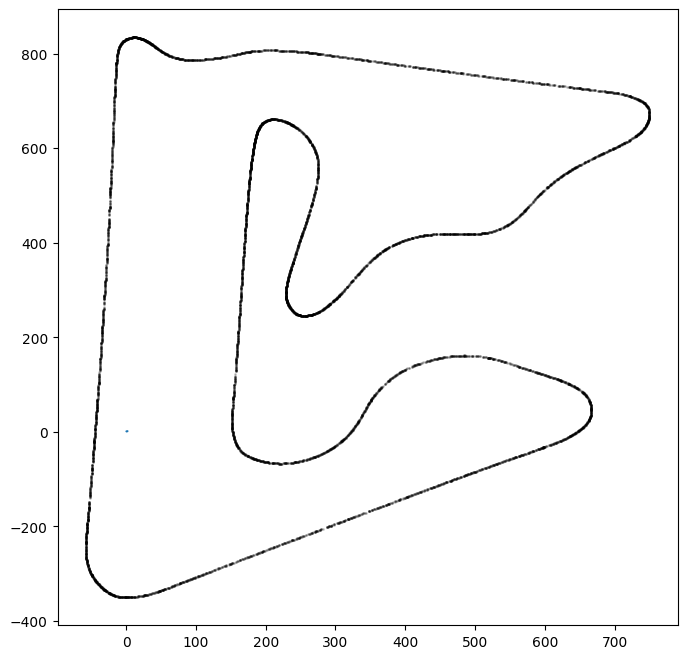

In [281]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_df_all = (
    df_timing[
        (df_timing['weekend_year']==2023)
        & (df_timing['weekend_index']==1)
        & (df_timing['lap_is_accurate'].fillna(False))
    ]
    .assign(time_=lambda df: df['Time'].apply(lambda x: x.total_seconds()))
)
plot_df = plot_df_all.sample(n=10000)
ax.scatter(plot_df['X']*0.1, plot_df['Y']*0.1, s=1, alpha=0.2, color='k')

transformer = LinearPointsToH3(5)
poly = transformer.cell_boundary(transformer.transform(0, 0))
ax.fill([x[0]*0.1 for x in poly], [x[1]*0.1 for x in poly])


In [296]:
transformer = LinearPointsToH3(1)
df_with_previous['current_cell'] = df_with_previous.apply(
    lambda row: transformer.transform(row['X'], row['Y']),
    axis=1,
)
df_with_previous['previous_cell'] = df_with_previous.apply(
    lambda row: transformer.transform(row['previous_X'], row['previous_Y']),
    axis=1,
)

In [303]:
cells = df_with_previous.query('(previous_cell!="0")&(current_cell!="0")').assign(count=1).groupby(
    ['previous_cell', 'current_cell'], as_index=False
).agg({'count': 'sum'})

In [304]:
cells_curr = cells.groupby(['current_cell']).agg({'count': 'sum'})
len(cells_curr)

8353

<AxesSubplot: ylabel='Frequency'>

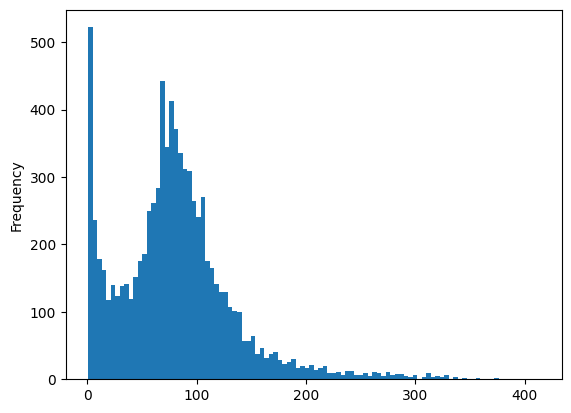

In [305]:
cells_curr['count'].plot.hist(bins=100)

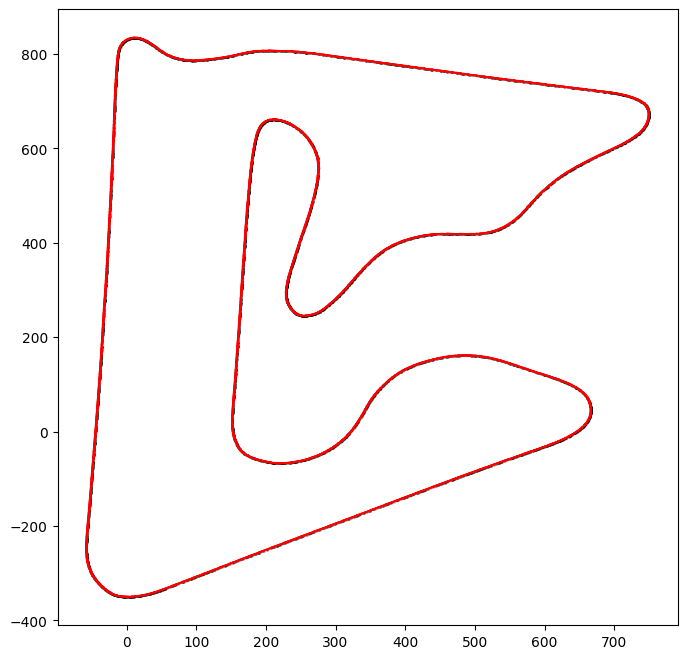

In [306]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_df_all = (
    df_timing[
        (df_timing['weekend_year']==2023)
        & (df_timing['weekend_index']==1)
        & (df_timing['lap_is_accurate'].fillna(False))
    ]
    .assign(time_=lambda df: df['Time'].apply(lambda x: x.total_seconds()))
)
plot_df = plot_df_all.sample(n=10000)
ax.scatter(plot_df['X']*0.1, plot_df['Y']*0.1, s=1, alpha=0.2, color='k')

for cell in cells_curr.index:
    poly = transformer.cell_boundary(cell)
    ax.fill([x[0]*0.1 for x in poly], [x[1]*0.1 for x in poly], color='r')

In [307]:
cells_curr

,count
current_cell,
8f754a9324b6401,126
8f754a9324b6403,74
8f754a9324b6405,85
8f754a9324b6418,116
8f754a9324b641b,114
...,...
8f754e64dad4d99,12
8f754e64dad4d9c,64
8f754e64dad4d9d,190


In [309]:
cells['previous_cell'].min(), cells['previous_cell'].max()

('8f754a9324b6401', '8f754e64dad4db3')

In [310]:
cells['current_cell'].min(), cells['current_cell'].max()

('8f754a9324b6401', '8f754e64dad4db3')

In [317]:
p0 = cells['previous_cell'].nunique()
p1 = cells['current_cell'].nunique()
p2 = len(cells)
print(p0, p1, p2)
p2 / ((p0+p1)/2)

8354 8353 203991


24.419824025857427

<AxesSubplot: ylabel='Frequency'>

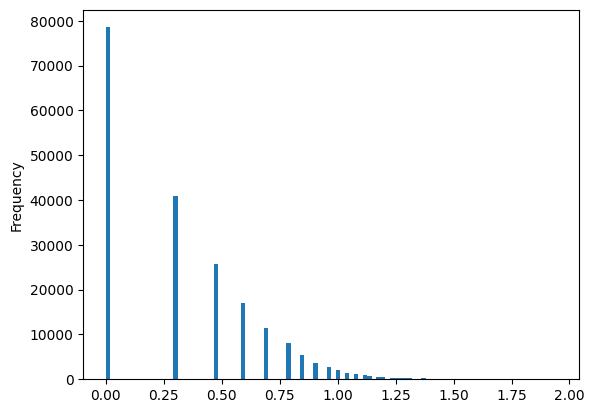

In [319]:
cells['count'].apply(np.log10).plot.hist(bins=100)

In [325]:
cells['count'].clip(upper=10).value_counts(normalize=True).sort_index()

1     0.385041
2     0.200563
3     0.125765
4     0.083504
5     0.056287
6     0.039330
7     0.027075
8     0.018246
9     0.013010
10    0.051179
Name: count, dtype: float64

In [451]:
HEX_BASIS = [
    np.array([1, 0]),
    np.array([-1/2, +np.sqrt(3)/2]),
    np.array([-1/2, -np.sqrt(3)/2]),
]
def update_hexcoords(hexcoords, displacement):
    return (
        hexcoords
        + displacement[0] * np.array([-1, +0.5, +0.5])
        + displacement[1] * np.array([+0.5, -1, +0.5])
    )

def find_hexagon(coords_xy: np.array):
    hexcoords = np.array([np.sum([np.dot(coords_xy, basis)]) for basis in HEX_BASIS])
    displacement = np.array([
        np.round(coords_xy[0] + coords_xy[1] / np.sqrt(3)),
        np.round(coords_xy[1] * 2 / np.sqrt(3)),
    ])
    hexcoords = update_hexcoords(hexcoords, displacement)
    orig_hexcoords = hexcoords.copy()
    ct = 0
    while max(abs(hexcoords)) > +0.5:
        idx_max = hexcoords.argmax()
        idx_min = hexcoords.argmin()
        if (hexcoords[idx_max] > +0.5) and (idx_max == 0):
            new_disp = np.array([1, 0])
        elif (hexcoords[idx_max] > +0.5) and (idx_max == 1):
            new_disp = np.array([0, 1])
        elif (hexcoords[idx_max] > +0.5) and (idx_max == 2):
            new_disp = np.array([-1, -1])
        elif (hexcoords[idx_min] < -0.5) and (idx_min == 0):
            new_disp = np.array([-1, 0])
        elif (hexcoords[idx_min] < -0.5) and (idx_min == 1):
            new_disp = np.array([0, -1])
        elif (hexcoords[idx_min] < -0.5) and (idx_min == 2):
            new_disp = np.array([1, 1])
        hexcoords = update_hexcoords(hexcoords, new_disp)
        displacement += new_disp
        ct += 1
    coords_ijk = np.array(list(displacement) + [0])
    min_ = min(coords_ijk)
    if min_ < 0:
        coords_ijk -= min_
    return displacement, hexcoords, ct, orig_hexcoords, tuple([int(round(x)) for x in coords_ijk])

In [452]:
find_hexagon(np.array([5.41, 8]))

(array([10.,  9.]),
 array([-0.09      ,  0.22320323, -0.13320323]),
 0,
 array([-0.09      ,  0.22320323, -0.13320323]),
 (10, 9, 0))

In [453]:
tests = -500 + 1000*np.random.random((100000, 2))

In [454]:
hexes_ = [find_hexagon(x) for x in tests]

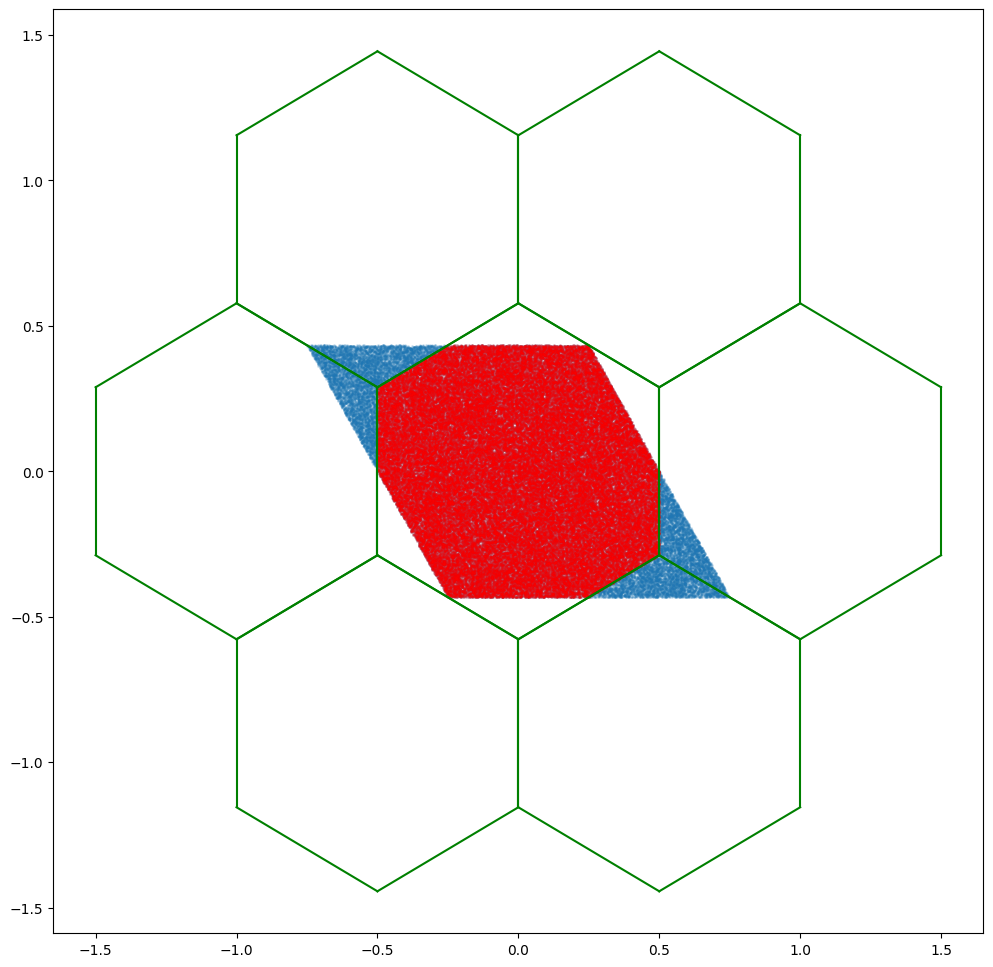

In [455]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    [x[3][0] for x in hexes_],
    [(x[3][1] + 0.5*x[3][0])*(2/np.sqrt(3)) for x in hexes_],
    s=1, alpha=0.2
)
ax.scatter(
    [x[3][0] for x in hexes_ if x[2]==0],
    [(x[3][1] + 0.5*x[3][0])*(2/np.sqrt(3)) for x in hexes_ if x[2]==0],
    s=1, alpha=0.2, color='r'
)
# for pt in [np.sqrt(3)/4, -np.sqrt(3)/4]:
#     ax.axhline(pt, color='k')
# for pt in [3/4, -3/4, 1/4, -1/4]:
#     ax.axvline(pt, color='k')
boundary = [
    (1/np.sqrt(3)) * np.array([np.cos(ang), np.sin(ang)])
    for ang in np.linspace(np.pi/6, np.pi/6 + 2*np.pi, 7)
]
for ptA, ptB in zip(boundary, boundary[1:]):
    ax.plot([ptA[0], ptB[0]], [ptA[1], ptB[1]], 'g-')
    for disp in [(1, 0), (-1,0), (0.5, np.sqrt(3)/2), (-0.5, np.sqrt(3)/2), (0.5, -np.sqrt(3)/2), (-0.5, -np.sqrt(3)/2)]:
        ax.plot([ptA[0]+disp[0], ptB[0]+disp[0]], [ptA[1]+disp[1], ptB[1]+disp[1]], 'g-')



In [456]:
collections.Counter([x[2] for x in hexes_])

Counter({0: 83241, 1: 12688, 2: 4071})

In [457]:
[x[4] for x in hexes_]

[(0, 476, 140),
 (137, 391, 0),
 (422, 265, 0),
 (102, 329, 0),
 (0, 333, 665),
 (86, 183, 0),
 (595, 338, 0),
 (575, 317, 0),
 (12, 293, 0),
 (0, 17, 92),
 (436, 0, 63),
 (214, 0, 172),
 (504, 0, 340),
 (203, 0, 349),
 (46, 380, 0),
 (0, 252, 384),
 (270, 0, 555),
 (225, 0, 457),
 (0, 563, 242),
 (568, 246, 0),
 (364, 0, 130),
 (494, 0, 105),
 (110, 95, 0),
 (0, 539, 174),
 (608, 0, 234),
 (0, 718, 229),
 (351, 350, 0),
 (0, 404, 195),
 (0, 643, 204),
 (363, 0, 402),
 (459, 276, 0),
 (302, 0, 275),
 (319, 0, 84),
 (0, 357, 344),
 (637, 0, 512),
 (291, 0, 296),
 (39, 0, 310),
 (23, 0, 507),
 (0, 391, 138),
 (0, 197, 124),
 (711, 489, 0),
 (0, 634, 94),
 (0, 399, 58),
 (590, 338, 0),
 (0, 379, 503),
 (46, 0, 65),
 (762, 526, 0),
 (459, 464, 0),
 (409, 169, 0),
 (0, 103, 30),
 (0, 415, 239),
 (379, 0, 353),
 (700, 443, 0),
 (0, 307, 658),
 (606, 0, 498),
 (0, 362, 360),
 (0, 663, 251),
 (282, 405, 0),
 (0, 694, 221),
 (0, 463, 375),
 (0, 90, 147),
 (545, 143, 0),
 (0, 345, 26),
 (0, 667,

In [458]:
def coords_to_hex(coords_xy: np.array):
    ret = find_hexagon(coords_xy)
    return ret[4]

In [460]:
coords_to_hex(np.array([0.4, 987.1]))

(570, 1140, 0)

In [461]:
df_timing

,Date,Status,X,Y,Z,Source,Time,SessionTime,lap_number,driver_id,...,weekend_index,session_index,session_start_time,t0_date,created_at,start_timestamp,end_timestamp,session_reference_time,session_start_time_dup,lap_is_accurate
0,2023-03-05 15:03:38.686,OnTrack,-280,3559,-157,pos,0 days 00:00:00.185000,0 days 01:02:36.837000,1,1,...,1,5,0 days 01:02:36.652000,2023-03-05 14:01:01.849,2023-06-01 02:21:03.229297,2023-03-05 15:03:38.501000+00:00,2023-03-05 15:05:17.810000+00:00,2023-03-05 14:01:01.849000+00:00,2023-03-05 15:03:38.501000+00:00,False
1,2023-03-05 15:03:38.946,OnTrack,-280,3559,-157,pos,0 days 00:00:00.445000,0 days 01:02:37.097000,1,1,...,1,5,0 days 01:02:36.652000,2023-03-05 14:01:01.849,2023-06-01 02:21:03.229297,2023-03-05 15:03:38.501000+00:00,2023-03-05 15:05:17.810000+00:00,2023-03-05 14:01:01.849000+00:00,2023-03-05 15:03:38.501000+00:00,False
2,2023-03-05 15:03:39.046,OnTrack,-280,3559,-157,pos,0 days 00:00:00.545000,0 days 01:02:37.197000,1,1,...,1,5,0 days 01:02:36.652000,2023-03-05 14:01:01.849,2023-06-01 02:21:03.229297,2023-03-05 15:03:38.501000+00:00,2023-03-05 15:05:17.810000+00:00,2023-03-05 14:01:01.849000+00:00,2023-03-05 15:03:38.501000+00:00,False
3,2023-03-05 15:03:39.265,OnTrack,-280,3564,-157,pos,0 days 00:00:00.764000,0 days 01:02:37.416000,1,1,...,1,5,0 days 01:02:36.652000,2023-03-05 14:01:01.849,2023-06-01 02:21:03.229297,2023-03-05 15:03:38.501000+00:00,2023-03-05 15:05:17.810000+00:00,2023-03-05 14:01:01.849000+00:00,2023-03-05 15:03:38.501000+00:00,False
4,2023-03-05 15:03:39.625,OnTrack,-279,3579,-157,pos,0 days 00:00:01.124000,0 days 01:02:37.776000,1,1,...,1,5,0 days 01:02:36.652000,2023-03-05 14:01:01.849,2023-06-01 02:21:03.229297,2023-03-05 15:03:38.501000+00:00,2023-03-05 15:05:17.810000+00:00,2023-03-05 14:01:01.849000+00:00,2023-03-05 15:03:38.501000+00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903359,2023-03-18 17:21:14.249,OnTrack,-18631,-6898,0,pos,0 days 00:02:08.774000,0 days 00:36:14.145000,10,21,...,2,4,0 days 00:15:00.037000,2023-03-18 16:45:00.104,2023-06-01 02:22:21.962810,2023-03-18 17:19:05.475000+00:00,2023-03-18 17:21:14.157000+00:00,2023-03-18 16:45:00.104000+00:00,2023-03-18 17:00:00.141000+00:00,False
9903360,2023-03-18 17:21:14.429,OnTrack,-18631,-6898,0,pos,0 days 00:02:08.954000,0 days 00:36:14.325000,10,21,...,2,4,0 days 00:15:00.037000,2023-03-18 16:45:00.104,2023-06-01 02:22:21.962810,2023-03-18 17:19:05.475000+00:00,2023-03-18 17:21:14.157000+00:00,2023-03-18 16:45:00.104000+00:00,2023-03-18 17:00:00.141000+00:00,False
9903361,2023-03-18 17:21:14.689,OnTrack,-18631,-6898,0,pos,0 days 00:02:09.214000,0 days 00:36:14.585000,10,21,...,2,4,0 days 00:15:00.037000,2023-03-18 16:45:00.104,2023-06-01 02:22:21.962810,2023-03-18 17:19:05.475000+00:00,2023-03-18 17:21:14.157000+00:00,2023-03-18 16:45:00.104000+00:00,2023-03-18 17:00:00.141000+00:00,False
9903362,2023-03-18 17:21:14.989,OnTrack,-18631,-6898,0,pos,0 days 00:02:09.514000,0 days 00:36:14.885000,10,21,...,2,4,0 days 00:15:00.037000,2023-03-18 16:45:00.104,2023-06-01 02:22:21.962810,2023-03-18 17:19:05.475000+00:00,2023-03-18 17:21:14.157000+00:00,2023-03-18 16:45:00.104000+00:00,2023-03-18 17:00:00.141000+00:00,False


In [462]:
vec = df_timing[['X', 'Y']].values

In [464]:
vec.shape

(9903364, 2)

In [469]:
cells_ = [coords_to_hex(x/50) for x in vec[:]]

KeyboardInterrupt: 

In [468]:
cells_

[(35, 82, 0),
 (35, 82, 0),
 (35, 82, 0),
 (35, 82, 0),
 (36, 83, 0),
 (36, 83, 0),
 (36, 83, 0),
 (37, 85, 0),
 (38, 86, 0),
 (38, 87, 0),
 (39, 88, 0),
 (39, 89, 0),
 (40, 90, 0),
 (40, 91, 0),
 (42, 94, 0),
 (43, 96, 0),
 (44, 98, 0),
 (45, 100, 0),
 (47, 103, 0),
 (47, 104, 0),
 (49, 107, 0),
 (51, 111, 0),
 (54, 117, 0),
 (56, 121, 0),
 (57, 123, 0),
 (59, 127, 0),
 (60, 128, 0),
 (62, 132, 0),
 (63, 134, 0),
 (66, 140, 0),
 (69, 145, 0),
 (71, 149, 0),
 (73, 153, 0),
 (74, 155, 0),
 (77, 160, 0),
 (78, 163, 0),
 (79, 165, 0),
 (81, 168, 0),
 (83, 173, 0),
 (85, 175, 0),
 (87, 179, 0),
 (88, 182, 0),
 (90, 185, 0),
 (92, 188, 0),
 (92, 188, 0),
 (93, 189, 0),
 (95, 191, 0),
 (96, 192, 0),
 (98, 193, 0),
 (99, 193, 0),
 (100, 193, 0),
 (100, 192, 0),
 (101, 191, 0),
 (102, 190, 0),
 (102, 188, 0),
 (103, 188, 0),
 (103, 185, 0),
 (104, 185, 0),
 (104, 184, 0),
 (106, 183, 0),
 (107, 182, 0),
 (108, 182, 0),
 (110, 182, 0),
 (111, 182, 0),
 (113, 182, 0),
 (115, 182, 0),
 (116, 182,

In [678]:
MATRIX_A = np.array([[1, 0], [1/np.sqrt(3), 2/np.sqrt(3)]])
MATRIX_B = np.array([[1, 0], [-0.5, np.sqrt(3)/2]])
MATRIX_C = np.array([[1, -0.5, -0.5], [0, np.sqrt(3)/2, -np.sqrt(3)/2]])
MATRIX_D = np.array([[1, -0.5, -0.5], [-0.5, 1, -0.5]])

def find_hexagon_arr(coords_xy: np.array, pre_displace=True, use_v1=False):
    if pre_displace:
        displacement_0 = np.round(np.dot(coords_xy, MATRIX_A))
    else:
        displacement_0 = np.zeros((coords_xy.shape[0], 2))
    coords_xy_displaced = coords_xy - np.dot(displacement_0, MATRIX_B)
    coords_ijk_displaced = np.dot(coords_xy_displaced, MATRIX_C)

    if use_v1:
        find_hexagon_arr_p2 = find_hexagon_arr_p2_v1
    else:
        find_hexagon_arr_p2 = find_hexagon_arr_p2_v0

    displacement_1, coords_ijk_displaced = find_hexagon_arr_p2(coords_ijk_displaced)
    return (displacement_0, displacement_1), coords_ijk_displaced

def find_hexagon_arr_p2_v0(coords_ijk):
    disp = np.zeros((coords_ijk.shape[0], 2))
    while True:
        should_break = True
        while max(coords_ijk[:, 0]) > +0.5:
            flter = (coords_ijk[:, 0] > +0.5)
            if flter.sum() > 0:
                should_break = False
            new_disp = np.outer(flter.astype(int), np.array([+1,0]))
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        while min(coords_ijk[:, 0]) < -0.5:
            flter = (coords_ijk[:, 0] < -0.5)
            if flter.sum() > 0:
                should_break = False
            new_disp = np.outer(flter.astype(int), np.array([-1,0]))
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        while max(coords_ijk[:, 1]) > +0.5:
            flter = (coords_ijk[:, 1] > +0.5)
            if flter.sum() > 0:
                should_break = False
            new_disp = np.outer(flter.astype(int), np.array([0,+1]))
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        while min(coords_ijk[:, 1]) < -0.5:
            flter = (coords_ijk[:, 1] < -0.5)
            if flter.sum() > 0:
                should_break = False
            new_disp = np.outer(flter.astype(int), np.array([0,-1]))
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        while max(coords_ijk[:, 2]) > +0.5:
            flter = (coords_ijk[:, 2] > +0.5)
            if flter.sum() > 0:
                should_break = False
            new_disp = np.outer(flter.astype(int), np.array([-1,-1]))
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        while min(coords_ijk[:, 2]) < -0.5:
            flter = (coords_ijk[:, 2] < -0.5)
            if flter.sum() > 0:
                should_break = False
            new_disp = np.outer(flter.astype(int), np.array([+1,+1]))
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        if should_break:
            break

    return disp, coords_ijk



def find_hexagon_arr_p2_v1(coords_ijk):
    disp = np.zeros((coords_ijk.shape[0], 2))
    plan_ = [
        (lambda v: np.floor(v[:, 0] + 0.5), np.array([+1,0])),
        (lambda v: np.floor(v[:, 1] + 0.5), np.array([0,+1])),
        (lambda v: np.floor(v[:, 2] + 0.5), np.array([-1,-1])),
    ]
    while True:
        should_break = True
        for plan in plan_:
            change = plan[0](coords_ijk)
            if abs(change).sum() > 0:
                should_break = False
            new_disp = np.outer(change, plan[1])
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        if should_break:
            break
    return disp, coords_ijk




    # displacement_1 = np.zeros_like(displacement_0)
    # flter = 
    # displacement_1[:, 0] += +1 * (coords_ijk_displaced[:, 0] > +0.5).astype(int)
    # displacement_1[:, 0] += -1 * (coords_ijk_displaced[:, 0] < -0.5).astype(int)

    # displacement_0 += displacement_1
    # coords_xy_displaced = coords_xy_displaced - np.dot(displacement_1, MATRIX_B)
    # coords_ijk_displaced = np.dot(coords_xy_displaced, MATRIX_C)


    return displacement_0, coords_xy_displaced, coords_ijk_displaced
    


    # hexcoords = np.array([np.sum([np.dot(coords_xy, basis)]) for basis in HEX_BASIS])
    # displacement = np.array([
    #     np.round(coords_xy[0] + coords_xy[1] / np.sqrt(3)),
    #     np.round(coords_xy[1] * 2 / np.sqrt(3)),
    # ])
    # hexcoords = update_hexcoords(hexcoords, displacement)
    # orig_hexcoords = hexcoords.copy()
    # ct = 0
    # while max(abs(hexcoords)) > +0.5:
    #     idx_max = hexcoords.argmax()
    #     idx_min = hexcoords.argmin()
    #     if (hexcoords[idx_max] > +0.5) and (idx_max == 0):
    #         new_disp = np.array([1, 0])
    #     elif (hexcoords[idx_max] > +0.5) and (idx_max == 1):
    #         new_disp = np.array([0, 1])
    #     elif (hexcoords[idx_max] > +0.5) and (idx_max == 2):
    #         new_disp = np.array([-1, -1])
    #     elif (hexcoords[idx_min] < -0.5) and (idx_min == 0):
    #         new_disp = np.array([-1, 0])
    #     elif (hexcoords[idx_min] < -0.5) and (idx_min == 1):
    #         new_disp = np.array([0, -1])
    #     elif (hexcoords[idx_min] < -0.5) and (idx_min == 2):
    #         new_disp = np.array([1, 1])
    #     hexcoords = update_hexcoords(hexcoords, new_disp)
    #     displacement += new_disp
    #     ct += 1

In [591]:
HEX_BASIS = [
    np.array([1, 0]),
    np.array([-1/2, +np.sqrt(3)/2]),
    np.array([-1/2, -np.sqrt(3)/2]),
]
def update_hexcoords(hexcoords, displacement):
    return (
        hexcoords
        + displacement[0] * np.array([-1, +0.5, +0.5])
        + displacement[1] * np.array([+0.5, -1, +0.5])
    )


In [592]:
vec = df_telemetry[['X', 'Y']].sample(n=100_000).values / 50.0
vec.shape

(100000, 2)

In [593]:
displacement = np.round(np.dot(
    vec,    
    np.array([[1, 0], [1/np.sqrt(3), 2/np.sqrt(3)]])    
))
displacement.shape

(100000, 2)

In [545]:
displacement

array([[-421., -167.],
       [   0.,    0.],
       [ 151.,  184.],
       ...,
       [  64.,  354.],
       [-237., -195.],
       [  76.,   84.]])

In [597]:
vec = -50 + 100 * np.random.random((100_000, 2))

In [631]:
out = find_hexagon_arr(vec)

In [632]:
out

(array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 1.]]),
 array([[-0.07769448,  0.01349706,  0.06419742],
        [-0.29148268,  0.23564405,  0.05583864],
        [ 0.07940262, -0.12743221,  0.04802959],
        ...,
        [ 0.18121744, -0.26275192,  0.08153448],
        [ 0.14622662, -0.14974262,  0.003516  ],
        [ 0.17408726, -0.48419594,  0.31010868]]))

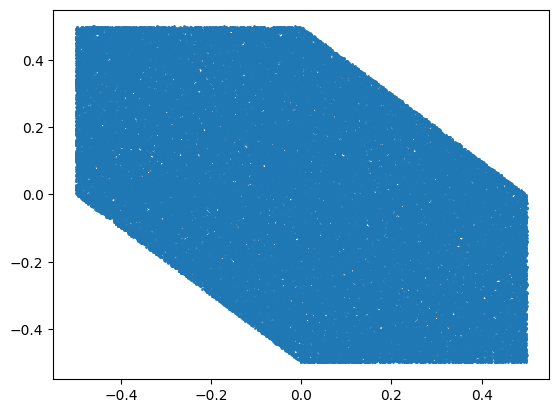

In [633]:
fig, ax = plt.subplots()
ax.scatter(out[1][:, 0], out[1][:, 2], s=1 )

In [636]:
out

(array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 1.]]),
 array([[-0.07769448,  0.01349706,  0.06419742],
        [-0.29148268,  0.23564405,  0.05583864],
        [ 0.07940262, -0.12743221,  0.04802959],
        ...,
        [ 0.18121744, -0.26275192,  0.08153448],
        [ 0.14622662, -0.14974262,  0.003516  ],
        [ 0.17408726, -0.48419594,  0.31010868]]))

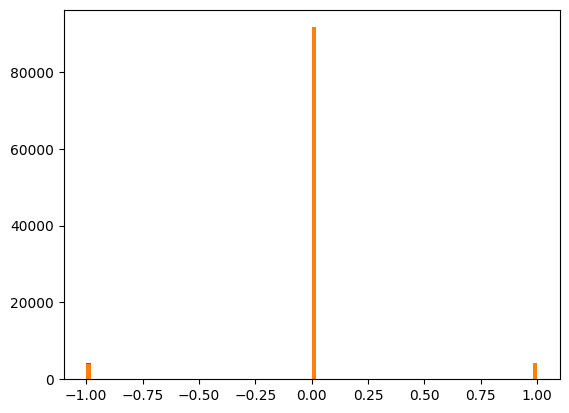

In [639]:
fig, ax = plt.subplots()
ax.hist(out[0][:, 0], bins=100);
ax.hist(out[0][:, 1], bins=100);


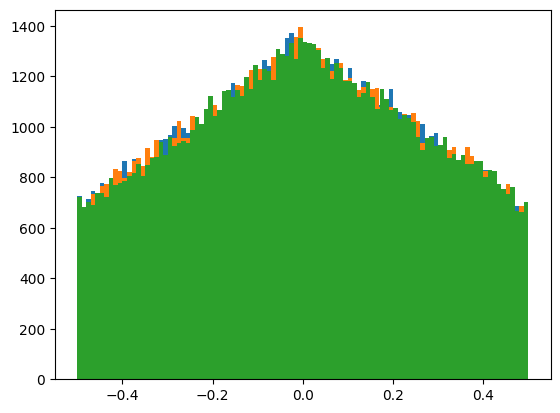

In [640]:
fig, ax = plt.subplots()
ax.hist(out[1][:, 0], bins=100);
ax.hist(out[1][:, 1], bins=100);
ax.hist(out[1][:, 2], bins=100);

In [608]:
out[1].sum(axis=1).round()

array([ 0.,  0.,  0., ...,  0., -0., -0.])

In [539]:
pd.Series(out[1][:, 2]).plot.hist(bins=100)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [496]:
pd.Series(out[1][:, 1]).plot.hist(bins=100)

array([[  -5.6 ,   71.18],
       [  -5.6 ,   71.18],
       [  -5.6 ,   71.18],
       ...,
       [-372.62, -137.96],
       [-372.62, -137.96],
       [-372.62, -137.96]])

In [497]:
82 * np.sqrt(3)/2

71.01408311032397

In [610]:
q = (out[1][:, 0] > 0.5)

In [614]:
qq = np.outer(q.astype(int), np.array([1,0]))

In [618]:
qq.mean(axis=0)

array([0.06343, 0.     ])

In [679]:
vec = -50 + 100 * np.random.random((1_000_000, 2))

In [689]:
resA = find_hexagon_arr(vec, pre_displace=True, use_v1=False)

In [690]:
resB = find_hexagon_arr(vec, pre_displace=False, use_v1=True)


In [685]:
resA

((array([[  4.,  22.],
         [-22., -36.],
         [-27., -41.],
         ...,
         [ -6., -26.],
         [ 18., -24.],
         [-30., -21.]]),
  array([[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         ...,
         [ 0.,  0.],
         [ 0.,  0.],
         [-1.,  0.]])),
 array([[ 0.37083148, -0.00800409, -0.3628274 ],
        [ 0.12163901,  0.03574048, -0.1573795 ],
        [ 0.28890046, -0.18378606, -0.1051144 ],
        ...,
        [-0.40205821,  0.19005666,  0.21200155],
        [-0.07746207,  0.25829106, -0.18082899],
        [ 0.28831419,  0.1920655 , -0.48037969]]))

In [686]:
resB

((array([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
  array([[  4.,  22.],
         [-22., -36.],
         [-27., -41.],
         ...,
         [ -6., -26.],
         [ 18., -24.],
         [-31., -21.]])),
 array([[ 0.37083148, -0.00800409, -0.3628274 ],
        [ 0.12163901,  0.03574048, -0.1573795 ],
        [ 0.28890046, -0.18378606, -0.1051144 ],
        ...,
        [-0.40205821,  0.19005666,  0.21200155],
        [-0.07746207,  0.25829106, -0.18082899],
        [ 0.28831419,  0.1920655 , -0.48037969]]))

In [687]:
check = (resA[0][0] + resA[0][1]) - (resB[0][0] + resB[0][1])

In [688]:
check.flatten().min(), check.flatten().max()

(0.0, 0.0)

In [671]:
f = lambda v: np.floor(v[:, 0] + 0.5)

In [676]:
abs(f(out[1])).sum()

0.0

In [673]:
out[1]

array([[-0.07769448,  0.01349706,  0.06419742],
       [-0.29148268,  0.23564405,  0.05583864],
       [ 0.07940262, -0.12743221,  0.04802959],
       ...,
       [ 0.18121744, -0.26275192,  0.08153448],
       [ 0.14622662, -0.14974262,  0.003516  ],
       [ 0.17408726, -0.48419594,  0.31010868]])

In [691]:
def find_hexagon_arr_v2(coords_xy: np.array):
    coords_ijk = np.dot(coords_xy, MATRIX_C)
    disp = np.zeros((coords_ijk.shape[0], 2))
    plan_ = [
        (lambda v: np.floor(v[:, 0] + 0.5), np.array([+1,0])),
        (lambda v: np.floor(v[:, 1] + 0.5), np.array([0,+1])),
        (lambda v: np.floor(v[:, 2] + 0.5), np.array([-1,-1])),
    ]
    while True:
        should_break = True
        for plan in plan_:
            change = plan[0](coords_ijk)
            if abs(change).sum() > 0:
                should_break = False
            new_disp = np.outer(change, plan[1])
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        if should_break:
            break
    return disp, coords_ijk

In [692]:
resC = find_hexagon_arr_v2(vec)

In [693]:
check = (resA[0][0] + resA[0][1]) - (resC[0])

In [694]:
check.flatten().min(), check.flatten().max()

(0.0, 0.0)

In [695]:
resC

(array([[  4.,  22.],
        [-22., -36.],
        [-27., -41.],
        ...,
        [ -6., -26.],
        [ 18., -24.],
        [-31., -21.]]),
 array([[ 0.37083148, -0.00800409, -0.3628274 ],
        [ 0.12163901,  0.03574048, -0.1573795 ],
        [ 0.28890046, -0.18378606, -0.1051144 ],
        ...,
        [-0.40205821,  0.19005666,  0.21200155],
        [-0.07746207,  0.25829106, -0.18082899],
        [ 0.28831419,  0.1920655 , -0.48037969]]))

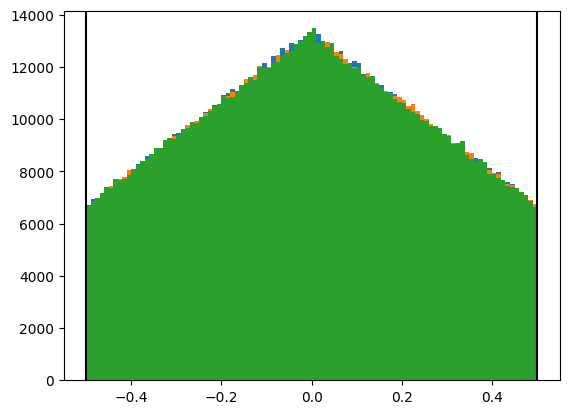

In [697]:
fig, ax = plt.subplots()
ax.hist(resC[1][:, 0], bins=100);
ax.hist(resC[1][:, 1], bins=100);
ax.hist(resC[1][:, 2], bins=100);
for lev in [0.5, -0.5]:
    ax.axvline(lev, color='k')

In [721]:
def plane_to_cell(coords_xy):
    disp, _ = find_hexagon_arr_v2(coords_xy)
    cell_coordinates = np.zeros((coords_xy.shape[0], 3))
    cell_coordinates[:, :2] = disp
    min_ = cell_coordinates.min(axis=1)
    change = - np.minimum(0, min_)
    cell_coordinates += np.outer(change, np.array([1,1,1]))
    return cell_coordinates

In [725]:
a = plane_to_cell(vec)
a

array([[ 4., 22.,  0.],
       [14.,  0., 36.],
       [14.,  0., 41.],
       ...,
       [20.,  0., 26.],
       [42.,  0., 24.],
       [ 0., 10., 31.]])

In [726]:
MATRIX_C

array([[ 1.       , -0.5      , -0.5      ],
       [ 0.       ,  0.8660254, -0.8660254]])

In [727]:
np.dot(MATRIX_C, MATRIX_C.T)

array([[1.5, 0. ],
       [0. , 1.5]])

In [728]:
np.dot(MATRIX_C.T, MATRIX_C)

array([[ 1. , -0.5, -0.5],
       [-0.5,  1. , -0.5],
       [-0.5, -0.5,  1. ]])

In [733]:
u,s,v = np.linalg.svd(MATRIX_C)
print(u.round(10))
print(s.round(10))
print(v.round(10))

[[-0. -1.]
 [ 1. -0.]]
[1.22474487 1.22474487]
[[ 0.          0.70710678 -0.70710678]
 [-0.81649658  0.40824829  0.40824829]
 [ 0.57735027  0.57735027  0.57735027]]


In [735]:
center = np.dot(a, MATRIX_C.T)

In [736]:
vec

array([[ -6.62916852,  19.25741622],
       [ -3.87836099, -31.06541666],
       [ -6.21109954, -35.55246266],
       ...,
       [  6.59794179, -22.52933039],
       [ 29.92253793, -20.53108361],
       [-20.21168581, -17.79829707]])

In [737]:
center

array([[ -7.        ,  19.05255888],
       [ -4.        , -31.17691454],
       [ -6.5       , -35.50704156],
       ...,
       [  7.        , -22.5166605 ],
       [ 30.        , -20.78460969],
       [-20.5       , -18.18653348]])

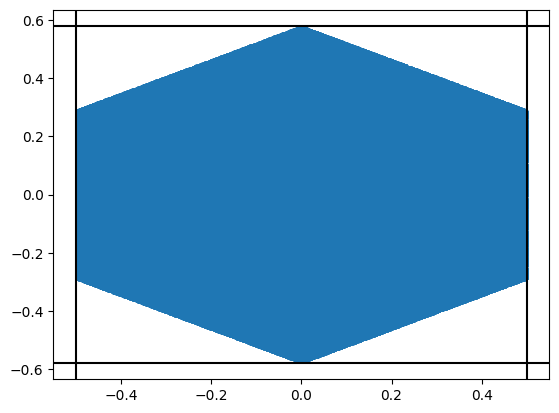

In [745]:
d = vec - center
fig, ax = plt.subplots()
ax.scatter(d[:, 0], d[:, 1], s=1);
for lev in [0.5, -0.5]:
    ax.axvline(lev, color='k');
for lev in [1/np.sqrt(3), -1/np.sqrt(3)]:
    ax.axhline(lev, color='k');


FINALLY: I HAVE THE H3 ALGORITHM FIGURED OUT

In [747]:
def plane_to_cell_as_in_h3(coords_xy):
    coords_ijk = np.dot(coords_xy, MATRIX_C)
    disp = np.zeros((coords_ijk.shape[0], 2))
    plan_ = [
        (lambda v: np.floor(v[:, 0] + 0.5), np.array([+1,0])),
        (lambda v: np.floor(v[:, 1] + 0.5), np.array([0,+1])),
        (lambda v: np.floor(v[:, 2] + 0.5), np.array([-1,-1])),
    ]
    while True:
        should_break = True
        for plan in plan_:
            change = plan[0](coords_ijk)
            if abs(change).sum() > 0:
                should_break = False
            new_disp = np.outer(change, plan[1])
            disp += new_disp
            coords_ijk -= np.dot(new_disp, MATRIX_D)
        if should_break:
            break
    cell_coordinates = np.zeros((coords_xy.shape[0], 3))
    cell_coordinates[:, :2] = disp
    min_ = cell_coordinates.min(axis=1)
    change = - np.minimum(0, min_)
    cell_coordinates += np.outer(change, np.array([1,1,1]))
    return cell_coordinates

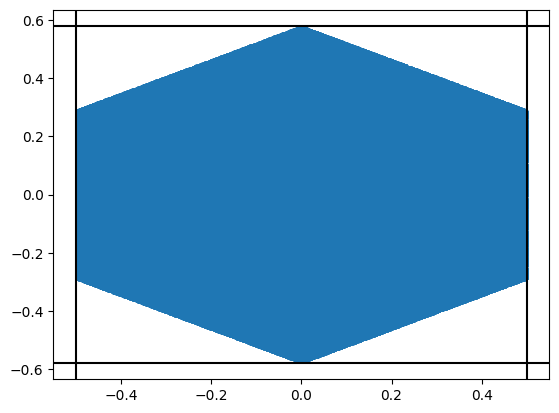

In [753]:
a = plane_to_cell_as_in_h3(vec)
center = np.dot(a, MATRIX_C.T)
d = vec - center

fig, ax = plt.subplots()
ax.scatter(d[:, 0], d[:, 1], s=1);
for lev in [0.5, -0.5]:
    ax.axvline(lev, color='k');
for lev in [1/np.sqrt(3), -1/np.sqrt(3)]:
    ax.axhline(lev, color='k');


In [757]:
df = df_telemetry[['X', 'Y']].reset_index(drop=True)
df

,X,Y
0,-280,3559
1,-280,3559
2,-280,3559
3,-280,3564
4,-279,3579
...,...,...
9903359,-18631,-6898
9903360,-18631,-6898
9903361,-18631,-6898
9903362,-18631,-6898


In [759]:
cell = plane_to_cell_as_in_h3(df[['X', 'Y']].values / 100)

In [768]:
df['cell'] = [tuple(x) for x in cell.round().astype(int)]

In [774]:
center = np.dot(cell, MATRIX_C.T) * 100
df[['center_X', 'center_Y']] = center

In [775]:
df

,X,Y,cell,center_X,center_Y
0,-280,3559,"(18, 41, 0)",-250.0,3550.704156
1,-280,3559,"(18, 41, 0)",-250.0,3550.704156
2,-280,3559,"(18, 41, 0)",-250.0,3550.704156
3,-280,3564,"(18, 41, 0)",-250.0,3550.704156
4,-279,3579,"(18, 41, 0)",-250.0,3550.704156
...,...,...,...,...,...
9903359,-18631,-6898,"(0, 146, 226)",-18600.0,-6928.203230
9903360,-18631,-6898,"(0, 146, 226)",-18600.0,-6928.203230
9903361,-18631,-6898,"(0, 146, 226)",-18600.0,-6928.203230
9903362,-18631,-6898,"(0, 146, 226)",-18600.0,-6928.203230


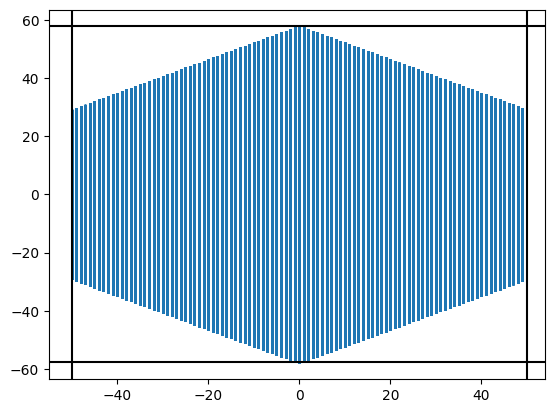

In [777]:
fig, ax = plt.subplots()
ax.scatter(df['X']-df['center_X'], df['Y']-df['center_Y'], s=1);
for lev in [0.5, -0.5]:
    ax.axvline(lev*100, color='k');
for lev in [1/np.sqrt(3), -1/np.sqrt(3)]:
    ax.axhline(lev*100, color='k');


In [809]:
class TransformerLikeH3:
    MATRIX_IJK = np.array([[1, -0.5, -0.5], [0, np.sqrt(3)/2, -np.sqrt(3)/2]])
    
    def __init__(self, scale_factor=1.0, rotation_angle=0.0):
        self.scale_factor = scale_factor
        self.rotation_angle = rotation_angle * np.pi / 180

    def _rotate(self, coords, inverse=False):
        cos_ = np.cos(self.rotation_angle)
        sin_ = np.sin(self.rotation_angle)
        if inverse:
            sin_ *= -1
        mat_rotate = np.array([[cos_, -sin_], [sin_, cos_]])
        return np.dot(coords, mat_rotate)
    
    def _scale(self, coords, inverse=False):
        factor = self.scale_factor
        if inverse:
            factor = 1 / factor
        return coords / factor
        
    def _to_cell(self, coords):
        coords_ijk = np.dot(coords, self.MATRIX_IJK)
        disp = np.zeros((coords_ijk.shape[0], 2))
        plan_ = [
            (lambda v: np.floor(v[:, 0] + 0.5), np.array([+1,0])),
            (lambda v: np.floor(v[:, 1] + 0.5), np.array([0,+1])),
            (lambda v: np.floor(v[:, 2] + 0.5), np.array([-1,-1])),
        ]
        while True:
            should_break = True
            for plan in plan_:
                change = plan[0](coords_ijk)
                if abs(change).sum() > 0:
                    should_break = False
                new_disp = np.outer(change, plan[1])
                disp += new_disp
                coords_ijk -= np.dot(new_disp, MATRIX_D)
            if should_break:
                break
        cell_coordinates = np.zeros((coords.shape[0], 3))
        cell_coordinates[:, :2] = disp
        min_ = cell_coordinates.min(axis=1)
        change = - np.minimum(0, min_)
        cell_coordinates += np.outer(change, np.array([1,1,1]))
        return cell_coordinates        

    def transform(self, coords):
        coords_ = self._scale(coords)
        coords_ = self._rotate(coords_)
        cells = self._to_cell(coords_)
        return cells

    def inverse_transform(self, cells):
        center = np.dot(cells, self.MATRIX_IJK.T)
        center = self._rotate(center, inverse=True)
        center = self._scale(center, inverse=True)
        return center

        

In [844]:
tr = TransformerLikeH3(scale_factor=100, rotation_angle=2)

In [845]:
vec_ = df[['X', 'Y']].values
a = tr.transform(vec_)
b = tr.inverse_transform(a)

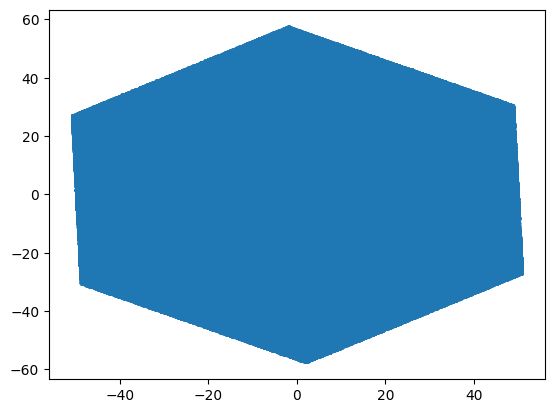

In [846]:
fig, ax = plt.subplots()
ax.scatter((vec_-b)[:,0], (vec_-b)[:,1], s=1, alpha=0.1);

In [843]:
a

array([[ 38.,  82.,   0.],
       [ 38.,  82.,   0.],
       [ 38.,  82.,   0.],
       ...,
       [  0., 305., 449.],
       [  0., 305., 449.],
       [  0., 305., 449.]])

In [847]:
a

array([[ 19.,  41.,   0.],
       [ 19.,  41.,   0.],
       [ 19.,  41.,   0.],
       ...,
       [  0., 153., 225.],
       [  0., 153., 225.],
       [  0., 153., 225.]])

In [1]:
2

2